# 281 Final Project Code
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Team Members: Alice Drozd, Richard Oldham, Kara Christensen

## Import Libraries

In [1]:
# Array, dataframe, and file manipulation
import numpy as np 
import pandas as pd 
import os
from pathlib import Path
from skimage.io import imread
import glob
from PIL import Image
from PIL import ImageOps


# Image features
import cv2 as cv
import skimage.feature
from scipy.stats import skew, kurtosis

# tSNE
from sklearn.manifold import TSNE

# Visulization
import seaborn as sns
import matplotlib.pyplot as plt

# Classification
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow import keras
from keras import metrics, layers, models
from keras import backend as K
from xgboost import XGBClassifier

# Various others
import time
import random
import dashtable

In [2]:
# Set to true to print out all example images
haveVisualizations = False

## Read in Data

In [3]:
# read in the file that contains each images information
df = pd.read_csv('../data/kidneyData.csv')
if haveVisualizations:
    display(df.head())
print('There are originally', len(df.index), 'images')

There are originally 12446 images


In [4]:
# save the new size that images will be saved to
newsize = (256, 256)

In [5]:
def getImagesInList(folder_dir):
    listOfImages = []
    for images in os.listdir(folder_dir): # For each item in the folder
        if (images.endswith(".jpg")): # If it is a jpg
            image = Image.open(folder_dir + '/' + images) # Open the image
            ogSize = np.asarray(image).shape # save the original shape
            if ogSize[0] != ogSize[1]: # if the image is not square, pad the image in the smaller dimension
                if ogSize[0]>ogSize[1]:
                    print('Doesn\'t happen in the data')
                else:
                    # pad to larger dim
                    image = ImageOps.pad(image, (ogSize[1], ogSize[1]), color=(0, 0, 0)) 
                    
            resizedSize = np.asarray(image).shape
            image = image.resize(newsize) # Resize it to the new size
            npImage = np.asarray(image) # Turn it into an array
            reshapedImage = npImage[:, :, 0] # Get rid of the last two color values (since it is black and white)
            
            # Add the information to the dictionary, add that dictionary to a list
            listOfImages.append({'image_id': images[:-4], 'original size': ogSize, 'resized size': resizedSize, 'image': reshapedImage}) 
            
    return listOfImages
    

In [6]:
# Get the correct folder of cyst images, then read them in
cyst_dir = "../data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst"

cystImages = getImagesInList(cyst_dir)

In [7]:
# Get the correct folder of normal images, then read them in
normal_dir = "../data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal"
normalImages = getImagesInList(normal_dir)

In [8]:
# Get the correct folder of stone images, then read them in
stone_dir = "../data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone"

stoneImages = getImagesInList(stone_dir)

In [9]:
# Get the correct folder of tumor images, then read them in
tumor_dir = "../data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor"

tumorImages = getImagesInList(tumor_dir)

## Preprocess Images

In [10]:
# Create dictionarys to translate numeric values to their catagorical meaning
labelDictionary = {0: 'Cyst', 1: 'Normal', 2: 'Stone', 3:'Tumor'}
coronalAxialDictionary = {0: 'Coronal', 1: 'Axial'}

In [11]:
def createXandYForCoronalAndAxial(imageListOfDicts, df):
    imageDF = pd.DataFrame(imageListOfDicts) # turn the list of dictionaries into a dataframe
    # extract the numeric value from the image_id
    imageDF['number'] = imageDF['image_id'].str.extract('\(([\d]+)\)', expand=False).astype(int) 
    imageDF = imageDF.sort_values(by = 'number').reset_index(drop = True) # sort based on image number, so each
                                                                            # patient's images are together
    # imageDF is a dataframe with them imageId, the image, and then the image number
#     display(imageDF)

    # Add the labels and make arrays
    imageDFWithLabel = imageDF.merge(df, how = 'inner', on = 'image_id') # join with the labels
    imageDFWithLabel = imageDFWithLabel[['image', 'target', 'original size']] # drop columns that are not necessary
    # Imaes that had an original size of (512, 512, 3) are Axial images, ientify these
    imageDFWithLabel["original size"] = imageDFWithLabel["original size"].astype(str)
#     return(imageDFWithLabel)
    imageDFWithLabel['coronalOrAxial'] = imageDFWithLabel['original size'] == "(512, 512, 3)"
    imageDFWithLabel["coronalOrAxial"] = imageDFWithLabel["coronalOrAxial"].astype(int)
    # imageDFWithLabel is a dataframe with the image, the target (class value), the original image size,
        # and if the image is coronal or axial

    # Spilt based on coronal and axial 
    coronalImageDFWithLabel = imageDFWithLabel[imageDFWithLabel["coronalOrAxial"] == 0].reset_index()
    axialImageDFWithLabel = imageDFWithLabel[imageDFWithLabel["coronalOrAxial"] == 1].reset_index()

    ####### Get Coronal Images into numpy arrays
    coronalX = coronalImageDFWithLabel['image'].to_numpy()
    coronaly = coronalImageDFWithLabel['target'].to_numpy()

    # Reshape the array to flatten the images
    coronalX = np.array([x for x in coronalX])
    nsamples, nx, ny = coronalX.shape
    coronalX = coronalX.reshape((nsamples,nx*ny))

    # Remove duplicate arrays with pandas and resplit into numpy
    coronalX_and_y = np.column_stack((coronalX, coronaly))
    coronalX_and_y = pd.DataFrame(coronalX_and_y)
    coronalX_and_y = coronalX_and_y.drop_duplicates()
    coronalX = coronalX_and_y.iloc[:,:-1].to_numpy()
    coronaly = coronalX_and_y.iloc[:,-1:].to_numpy()


    ####### Get Axial Images into numpy arrays
    axialX = axialImageDFWithLabel['image'].to_numpy()
    axialy = axialImageDFWithLabel['target'].to_numpy()

    # Reshape the array to flatten the images
    axialX = np.array([x for x in axialX])
    nsamples, nx, ny = axialX.shape
    axialX = axialX.reshape((nsamples,nx*ny))

    # Remove duplicate arrays with pandas and resplit into numpy
    axialX_and_y = np.column_stack((axialX, axialy))
    axialX_and_y = pd.DataFrame(axialX_and_y)
    axialX_and_y = axialX_and_y.drop_duplicates()
    axialX = axialX_and_y.iloc[:,:-1].to_numpy()
    axialy = axialX_and_y.iloc[:,-1:].to_numpy()

    # Return the coronal and axial features and targets
    return coronalX, coronaly, axialX, axialy

In [12]:
# cystWithSizes = createXandYForCoronalAndAxial(cystImages, df)
# normalWithSizes = createXandYForCoronalAndAxial(normalImages, df)
# stoneWithSizes = createXandYForCoronalAndAxial(stoneImages, df)
# tumorWithSizes = createXandYForCoronalAndAxial(tumorImages, df)

# allImagesWithSizes = pd.concat([cystWithSizes, normalWithSizes, stoneWithSizes, tumorWithSizes])
# allImagesWithSizes['first dim'] = allImagesWithSizes['original size'].str.extract('\(([\d]+),', expand=False).astype(int) 
# allImagesWithSizes['second dim'] = allImagesWithSizes['original size'].str.extract(', ([\d]+),', expand=False).astype(int)
# allImagesWithSizes['larger dim'] = np.maximum(allImagesWithSizes['first dim'], allImagesWithSizes['second dim'])
# allImagesWithSizes['ratio'] = allImagesWithSizes['first dim']/allImagesWithSizes['second dim']
# allImagesWithSizes['ratio'].unique()
# print(allImagesWithSizes.groupby('original size').size().reset_index().sort_values(by = 0, ascending = False))

In [13]:
coronalCystX, coronalCysty, axialCystX, axialCysty = createXandYForCoronalAndAxial(cystImages, df)

In [14]:
print('There are', coronalCystX.shape[0], 'coronal cyst images and', axialCystX.shape[0], 'axial cyst images')

There are 1404 coronal cyst images and 1880 axial cyst images


In [15]:
# 5 axial, 5 coronal
randomCoronalCystIndices = [random.randint(0, coronalCystX.shape[0]) for i in range(5)]
randomAxialCystIndices = [random.randint(0, axialCystX.shape[0]) for i in range(5)]
images = [(i, coronalCystX[i, :].reshape(newsize)) for i in randomCoronalCystIndices] + [(i, axialCystX[i, :].reshape(newsize)) for i in randomAxialCystIndices]

if haveVisualizations:
    # Create a figure and subplots
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))

    # Loop through the axes and images
    for ax, img in zip(axes.flatten(), images):
        ax.imshow(img[1], cmap='gray')  # Display each image
        ax.set_title('Index: '+ str(img[0]))
        ax.axis('off')  # Turn off the axis for a cleaner look

    # Adjust spacing
    plt.tight_layout()

    # Display the plot
    plt.show()

In [16]:
coronalNormalX, coronalNormaly, axialNormalX, axialNormaly = createXandYForCoronalAndAxial(normalImages, df)

In [17]:
print('There are', coronalNormalX.shape[0], 'coronal normal images and', axialNormalX.shape[0], 'axial normal images')

There are 1728 coronal normal images and 3274 axial normal images


In [18]:
# 5 axial, 5 coronal
randomCoronalNormalIndices = [random.randint(0, coronalNormalX.shape[0]) for i in range(5)]
randomAxialNormalIndices = [random.randint(0, axialNormalX.shape[0]) for i in range(5)]
images = [(i, coronalNormalX[i, :].reshape(newsize)) for i in randomCoronalNormalIndices] + [(i, axialNormalX[i, :].reshape(newsize)) for i in randomAxialNormalIndices]

if haveVisualizations:
    # Create a figure and subplots
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))

    # Loop through the axes and images
    for ax, img in zip(axes.flatten(), images):
        ax.imshow(img[1], cmap='gray')  # Display each image
        ax.set_title('Index: '+ str(img[0]))
        ax.axis('off')  # Turn off the axis for a cleaner look

    # Adjust spacing
    plt.tight_layout()

    # Display the plot
    plt.show()

In [19]:
coronalStoneX, coronalStoney, axialStoneX, axialStoney = createXandYForCoronalAndAxial(stoneImages, df)

In [20]:
print('There are', coronalStoneX.shape[0], 'coronal stone images and', axialStoneX.shape[0], 'axial stone images')

There are 519 coronal stone images and 841 axial stone images


In [21]:
# 5 axial, 5 coronal
randomCoronalStoneIndices = [random.randint(0, coronalStoneX.shape[0]) for i in range(5)]
randomAxialStoneIndices = [random.randint(0, axialStoneX.shape[0]) for i in range(5)]
images = [(i, coronalStoneX[i, :].reshape(newsize)) for i in randomCoronalStoneIndices] + [(i, axialStoneX[i, :].reshape(newsize)) for i in randomAxialStoneIndices]

if haveVisualizations:
    # Create a figure and subplots
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))

    # Loop through the axes and images
    for ax, img in zip(axes.flatten(), images):
        ax.imshow(img[1], cmap='gray')  # Display each image
        ax.set_title('Index: '+ str(img[0]))
        ax.axis('off')  # Turn off the axis for a cleaner look

    # Adjust spacing
    plt.tight_layout()

    # Display the plot
    plt.show()

In [22]:
coronalTumorX, coronalTumory, axialTumorX, axialTumory = createXandYForCoronalAndAxial(tumorImages, df)

In [23]:
print('There are', coronalTumorX.shape[0], 'coronal tumor images and', axialTumorX.shape[0], 'axial tumor images')

There are 943 coronal tumor images and 1340 axial tumor images


In [24]:
# 5 axial, 5 coronal
randomCoronalTumorIndices = [random.randint(0, coronalTumorX.shape[0]) for i in range(5)]
randomAxialTumorIndices = [random.randint(0, axialTumorX.shape[0]) for i in range(5)]
images = [(i, coronalTumorX[i, :].reshape(newsize)) for i in randomCoronalTumorIndices] + [(i, axialTumorX[i, :].reshape(newsize)) for i in randomAxialTumorIndices]

if haveVisualizations:
    # Create a figure and subplots
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))

    # Loop through the axes and images
    for ax, img in zip(axes.flatten(), images):
        ax.imshow(img[1], cmap='gray')  # Display each image
        ax.set_title('Index: '+ str(img[0]))
        ax.axis('off')  # Turn off the axis for a cleaner look

    # Adjust spacing
    plt.tight_layout()

    # Display the plot
    plt.show()

## EDA

### Image Examples

In [25]:
allExampleCoronalImages = [('Cyst', coronalCystX[i, :].reshape(newsize)) for i in randomCoronalCystIndices[:2]] + [('Normal', coronalNormalX[i, :].reshape(newsize)) for i in randomCoronalNormalIndices[:2]] + [('Stone', coronalStoneX[i, :].reshape(newsize)) for i in randomCoronalStoneIndices[:2]] + [('Tumor', coronalTumorX[i, :].reshape(newsize)) for i in randomCoronalTumorIndices[:2]]
allExampleAxialImages = [('Cyst', axialCystX[i, :].reshape(newsize)) for i in randomAxialCystIndices[:2]] + [('Normal', axialNormalX[i, :].reshape(newsize)) for i in randomAxialNormalIndices[:2]] + [('Stone', axialStoneX[i, :].reshape(newsize)) for i in randomAxialStoneIndices[:2]] + [('Tumor', axialTumorX[i, :].reshape(newsize)) for i in randomAxialTumorIndices[:2]]

In [26]:
if haveVisualizations:
    # Create a figure and subplots for the coronal images
    fig, axes = plt.subplots(4, 2, figsize=(6, 12))

    # Loop through the axes and images
    for ax, img in zip(axes.flatten(), allExampleCoronalImages):
        ax.imshow(img[1], cmap='gray')  # Display each image
        ax.set_title('Catagory: '+ str(img[0]))
        ax.axis('off')  # Turn off the axis for a cleaner look
    fig.suptitle(' Coronal Example Images ', fontsize = 16)
    # Adjust spacing
    plt.tight_layout()

    # Display the plot
    plt.show()

In [27]:
if haveVisualizations:
    # Create a figure and subplots for the coronal images
    fig, axes = plt.subplots(4, 2, figsize=(6, 12))

    # Loop through the axes and images
    for ax, img in zip(axes.flatten(), allExampleAxialImages):
        ax.imshow(img[1], cmap='gray')  # Display each image
        ax.set_title('Catagory: '+ str(img[0]))
        ax.axis('off')  # Turn off the axis for a cleaner look
    fig.suptitle(' Axial Example Images ', fontsize = 16)
    # Adjust spacing
    plt.tight_layout()

    # Display the plot
    plt.show()

### Image Distribution by Class

In [28]:
# Get all target values
y_val_axial = np.concatenate((axialCysty, axialStoney, axialNormaly, axialTumory))
print('There are', len(y_val_axial), 'total Axial images')

if haveVisualizations:
    plt.figure(figsize=(10, 6))
    # Get the count of each unique target value
    unique, counts = np.unique(y_val_axial, return_counts=True)
    # Get the label of each target value
    uniqueLabels = [labelDictionary[x] for x in unique]
    # Make the bar plot
    sns.barplot(x=uniqueLabels, y=counts, palette="Spectral")
    plt.title('Axial Distribution', fontsize = 16)
    plt.show()

There are 7335 total Axial images


In [29]:
# Get all target values
y_val_coronal = np.concatenate((coronalCysty, coronalStoney, coronalNormaly, coronalTumory))
print('There are', len(y_val_coronal), 'total Coronal images')

if haveVisualizations:
    plt.figure(figsize=(10, 6))
    # Get the count of each unique target value
    unique, counts = np.unique(y_val_coronal, return_counts=True)
    # Get the label of each target value
    uniqueLabels = [labelDictionary[x] for x in unique]
    # Make the bar plot
    sns.barplot(x=uniqueLabels, y=counts, palette="Spectral")
    plt.title('Coronal Distribution', fontsize = 16)
    plt.show()

There are 4594 total Coronal images


## Create Train, Validation, and Test Sets

In [30]:
def createSplits(in_x, in_y):
    # Get the value that is 70% and 15% of the data
    split70 = int(np.floor(in_x.shape[0]*0.7))
    split15 = int(np.floor(in_x.shape[0]*0.15))
    
    # Perform the splits
    Xtrain = in_x[:split70] # Get the first 70% of the feature values
    Xval = in_x[split70:split70+split15] # Get from the 70% to 85% of the feature values
    Xtest = in_x[split70+split15:] # Get the final 15% of the feature values
    
    ytrain = in_y[:split70] # Get the first 70% of the target values
    yval = in_y[split70:split70+split15] # Get from the 70% to 85% of the target values
    ytest = in_y[split70+split15:] # Get the final 15% of the target values
    
    return Xtrain, Xval, Xtest, ytrain, yval, ytest

In [31]:
# Create the splits for the coronal and axial images within each class
### Cyst
coronalCystXTrain, coronalCystXVal, coronalCystXTest, coronalCystyTrain, coronalCystyVal, coronalCystyTest = createSplits(coronalCystX, coronalCysty)
axialCystXTrain, axialCystXVal, axialCystXTest, axialCystyTrain, axialCystyVal, axialCystyTest = createSplits(axialCystX, axialCysty)

### Normal
coronalNormalXTrain, coronalNormalXVal, coronalNormalXTest, coronalNormalyTrain, coronalNormalyVal, coronalNormalyTest = createSplits(coronalNormalX, coronalNormaly)
axialNormalXTrain, axialNormalXVal, axialNormalXTest, axialNormalyTrain, axialNormalyVal, axialNormalyTest = createSplits(axialNormalX, axialNormaly)

### Stone
coronalStoneXTrain, coronalStoneXVal, coronalStoneXTest, coronalStoneyTrain, coronalStoneyVal, coronalStoneyTest = createSplits(coronalStoneX, coronalStoney)
axialStoneXTrain, axialStoneXVal, axialStoneXTest, axialStoneyTrain, axialStoneyVal, axialStoneyTest = createSplits(axialStoneX, axialStoney)

### Tumor
coronalTumorXTrain, coronalTumorXVal, coronalTumorXTest, coronalTumoryTrain, coronalTumoryVal, coronalTumoryTest = createSplits(coronalTumorX, coronalTumory)
axialTumorXTrain, axialTumorXVal, axialTumorXTest, axialTumoryTrain, axialTumoryVal, axialTumoryTest = createSplits(axialTumorX, axialTumory)



In [32]:
# Combine the feature and target train, validation, and test sets for coronal
### Make the feature train, validation, and test sets
X_train_coronal = np.concatenate((coronalCystXTrain, coronalNormalXTrain, coronalStoneXTrain, coronalTumorXTrain))
X_val_coronal = np.concatenate((coronalCystXVal, coronalNormalXVal, coronalStoneXVal, coronalTumorXVal))
X_test_coronal = np.concatenate((coronalCystXTest, coronalNormalXTest, coronalStoneXTest, coronalTumorXTest))

### Make the target train, validation, and test sets
y_train_coronal = np.concatenate((coronalCystyTrain, coronalNormalyTrain, coronalStoneyTrain, coronalTumoryTrain))
y_val_coronal = np.concatenate((coronalCystyVal, coronalNormalyVal, coronalStoneyVal, coronalTumoryVal))
y_test_coronal = np.concatenate((coronalCystyTest, coronalNormalyTest, coronalStoneyTest, coronalTumoryTest))

### Display the sizes of these new sets
print('Coronal')
print('\tCoronal Training Size:', X_train_coronal.shape, 'Targets:', y_train_coronal.shape)
print('\tCoronal Validation Size:', X_val_coronal.shape, 'Targets:', y_val_coronal.shape)
print('\tCoronal Test Size:', X_test_coronal.shape, 'Targets:', y_test_coronal.shape)


# Combine the feature and target train, validation, and test sets for axial
### Make the feature train, validation, and test sets
X_train_axial = np.concatenate((axialCystXTrain, axialNormalXTrain, axialStoneXTrain, axialTumorXTrain))
X_val_axial = np.concatenate((axialCystXVal, axialNormalXVal, axialStoneXVal, axialTumorXVal))
X_test_axial = np.concatenate((axialCystXTest, axialNormalXTest, axialStoneXTest, axialTumorXTest))

### Make the target train, validation, and test sets
y_train_axial = np.concatenate((axialCystyTrain, axialNormalyTrain, axialStoneyTrain, axialTumoryTrain))
y_val_axial = np.concatenate((axialCystyVal, axialNormalyVal, axialStoneyVal, axialTumoryVal))
y_test_axial = np.concatenate((axialCystyTest, axialNormalyTest, axialStoneyTest, axialTumoryTest))

### Display the sizes of these new sets
print('\nAxial')
print('\tAxial Training Size:', X_train_axial.shape, 'Targets:', y_train_axial.shape)
print('\tAxial Validation Size:', X_val_axial.shape, 'Targets:', y_val_axial.shape)
print('\tAxial Test Size:', X_test_axial.shape, 'Targets:', y_test_axial.shape)

Coronal
	Coronal Training Size: (3214, 65536) Targets: (3214, 1)
	Coronal Validation Size: (687, 65536) Targets: (687, 1)
	Coronal Test Size: (693, 65536) Targets: (693, 1)

Axial
	Axial Training Size: (5132, 65536) Targets: (5132, 1)
	Axial Validation Size: (1100, 65536) Targets: (1100, 1)
	Axial Test Size: (1103, 65536) Targets: (1103, 1)


In [33]:
def shuffleSets (x_in, y_in): # This function will shuffle the data provided, ensuring the features and targets
                                # are both shuffled in the same way
    indices = np.arange(x_in.shape[0]) # Get a list of all values up to the number of values in the set
    shuffled_indices = np.random.permutation(indices) # Shuffle those values
    x_shuff = x_in[shuffled_indices] # Apply the shuffle to the features
    y_shuff = y_in[shuffled_indices] # Apply the shuffle to the targets
    
    return x_shuff, y_shuff

In [34]:
# Set a random seed
np.random.seed(42)

# Shuffle both training sets
X_train_coronal_shuff, y_train_coronal_shuff = shuffleSets(X_train_coronal, y_train_coronal)
X_train_axial_shuff, y_train_axial_shuff = shuffleSets(X_train_axial, y_train_axial)

# Shuffle both validation sets
X_val_coronal_shuff, y_val_coronal_shuff = shuffleSets(X_val_coronal, y_val_coronal)
X_val_axial_shuff, y_val_axial_shuff = shuffleSets(X_val_axial, y_val_axial)

# Shuffle both test sets
X_test_coronal_shuff, y_test_coronal_shuff = shuffleSets(X_test_coronal, y_test_coronal)
X_test_axial_shuff, y_test_axial_shuff = shuffleSets(X_test_axial, y_test_axial)


In [35]:
# Make a version of the target vector with the labels for visualization
y_train_coronal_shuff_labeled = np.vectorize(labelDictionary.get)(y_train_coronal_shuff)
y_val_coronal_shuff_labeled = np.vectorize(labelDictionary.get)(y_val_coronal_shuff)
y_test_coronal_shuff_labeled = np.vectorize(labelDictionary.get)(y_test_coronal_shuff)

y_train_axial_shuff_labeled = np.vectorize(labelDictionary.get)(y_train_axial_shuff)
y_val_axial_shuff_labeled = np.vectorize(labelDictionary.get)(y_val_axial_shuff)
y_test_axial_shuff_labeled = np.vectorize(labelDictionary.get)(y_test_axial_shuff)

## Scaling the Sets Based On Training Intensity Values

In [35]:
# # Create the scaler object for coronal images
# scaler_coronal = StandardScaler()
# scaler_coronal.fit(X_train_coronal_shuff) # Fit to the training set
# X_train_coronal_scaled = scaler_coronal.transform(X_train_coronal_shuff) # Scale the training set
# X_val_coronal_scaled = scaler_coronal.transform(X_val_coronal_shuff) # Scale the validation set
# X_test_coronal_scaled = scaler_coronal.transform(X_test_coronal_shuff) # Scale the test set

# # Create the scaler object for axial images
# scaler_axial = StandardScaler()
# scaler_axial.fit(X_train_axial_shuff) # Fit to the training set
# X_train_axial_scaled = scaler_coronal.transform(X_train_axial_shuff) # Scale the training set
# X_val_axial_scaled = scaler_coronal.transform(X_val_axial_shuff) # Scale the validation set
# X_test_axial_scaled = scaler_coronal.transform(X_test_axial_shuff) # Scale the test set

## Feature Extraction

In [36]:
def scaleAndPlotPCA(data, plotTitle):
    scaler = StandardScaler()
    scaler.fit(data)
    scaled_data = scaler.transform(data)

    pca = PCA()
    pca.fit(scaled_data)
    cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
    # Plotting
    plt.figure(figsize=(16, 8))
    plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance vs Number of Components: ' + plotTitle, fontsize = 16)
    plt.grid(True)
    plt.show()

In [37]:
def plotTSNE(data, yVals, plotTitle):
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    current_tSNE = tsne.fit_transform(data)


    current_tSNE_df = pd.DataFrame(current_tSNE, columns=["tSNE1", "tSNE2"])
    current_tSNE_df['Class'] = yVals.reshape(len(yVals))

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x="tSNE1", 
        y="tSNE2", 
        hue="Class", 
        palette="tab10", 
        data=current_tSNE_df, 
        alpha=0.7, 
        s=60
    )

    # Add title and legend
    plt.title(plotTitle, fontsize = 16)
    plt.legend(title="Digit Label", loc="upper right")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.grid(True)
    plt.show()

In [38]:
def scaleAndGetPCASets(train, val, test, threshold):
    scaler_PCA = StandardScaler()
    scaler_PCA.fit(train) # Fit to the training set
    train_scaled = scaler_PCA.transform(train) # Scale the training set
    val_scaled = scaler_PCA.transform(val) # Scale the validation set
    test_scaled = scaler_PCA.transform(test) # Scale the test set
    
    pca = PCA(n_components=threshold)  # Retain threshold% of variance
    train_pca = pca.fit_transform(train_scaled)  # Fit and transform on training data
    val_pca = pca.transform(val_scaled) 
    test_pca = pca.transform(test_scaled) 
    
    return train_scaled, val_scaled, test_scaled, train_pca, val_pca, test_pca
    
    

### HOG

In [39]:
def generateHogFeature(data, numOrientations, numPixelsPerCell):
    hogFeatures = [] # Create where the outputs will live
    for i in range(len(data)): # Iterate through all images
        img = data[i].reshape(newsize) # Reshape the image back to an image
        # Apply hog to get the feature vector
        f = skimage.feature.hog(img, orientations=numOrientations, pixels_per_cell=(numPixelsPerCell, numPixelsPerCell))
        hogFeatures.append(f) # Append the feature vector to the output list
        
    hogFeatures = np.array(hogFeatures) # turn the output list into a numpy array
        
    return hogFeatures

In [40]:
def visualizeHogExamples(exampleImages, numOrientations, numPixelsPerCell):
    cols = int(len(exampleImages)/2) # Get the number of columns from the number of example images
    fig, ax = plt.subplots(nrows=4, ncols=cols, figsize=(12,12)) # make a subplot

    for i, impath in enumerate(exampleImages): # For each image
        im_processed = impath[1] # Get the image
        # Get the HOG feature and visualization
        f, h = skimage.feature.hog(im_processed, orientations=numOrientations, pixels_per_cell=(numPixelsPerCell, numPixelsPerCell), visualize=True)

        if i < cols: # If its in the first half of images, display the image and its hog in the first two rows
            ax[0,i].imshow(im_processed, cmap='gray')
            ax[0,i].axis('off')
            ax[0,i].set_title(impath[0])
            ax[1,i].imshow(10*h, cmap='gray')
            ax[1,i].axis('off')
        else: # Otherwise, display the image and its hog in the final two rows
            ax[2,i-4].imshow(im_processed, cmap='gray')
            ax[2,i-4].axis('off')
            ax[2,i-4].set_title(impath[0])
            ax[3,i-4].imshow(10*h, cmap='gray')
            ax[3,i-4].axis('off')

    plt.tight_layout()
    plt.show() # Show the plots

#### Coronal HOG

In [41]:
if haveVisualizations:
    visualizeHogExamples(allExampleCoronalImages, 4, 10)

In [42]:
X_train_HOG_coronal = generateHogFeature(X_train_coronal_shuff, 4, 10)

In [43]:
if haveVisualizations:
    plotTSNE(X_train_HOG_coronal, y_train_coronal_shuff_labeled, "t-SNE Visualization of Coronal HOG")

In [44]:
X_val_HOG_coronal = generateHogFeature(X_val_coronal_shuff, 4, 10)
X_test_HOG_coronal = generateHogFeature(X_test_coronal_shuff, 4, 10)

In [45]:
if haveVisualizations:
    scaleAndPlotPCA(X_train_HOG_coronal, 'Coronal Images\nHOG Features')

In [46]:
scaler_coronal_HOG = StandardScaler()
scaler_coronal_HOG.fit(X_train_HOG_coronal) # Fit to the training set
X_train_HOG_coronal_scaled = scaler_coronal_HOG.transform(X_train_HOG_coronal) # Scale the training set
X_val_HOG_coronal_scaled = scaler_coronal_HOG.transform(X_val_HOG_coronal) # Scale the validation set
X_test_HOG_coronal_scaled = scaler_coronal_HOG.transform(X_test_HOG_coronal) # Scale the test set

In [47]:
pca_coronal_HOG = PCA(n_components=0.95)  # Retain 95% of variance
X_train_HOG_coronal_pca = pca_coronal_HOG.fit_transform(X_train_HOG_coronal_scaled)  # Fit and transform on training data
X_val_HOG_coronal_pca = pca_coronal_HOG.transform(X_val_HOG_coronal_scaled) 
X_test_HOG_coronal_pca = pca_coronal_HOG.transform(X_test_HOG_coronal_scaled) 

#### Axial HOG

In [48]:
if haveVisualizations:
    visualizeHogExamples(allExampleAxialImages, 4, 10)

In [49]:
X_train_HOG_axial = generateHogFeature(X_train_axial_shuff, 4, 10)

In [50]:
if haveVisualizations:
    plotTSNE(X_train_HOG_axial, y_train_axial_shuff_labeled, "t-SNE Visualization of Axial HOG")

In [51]:
X_val_HOG_axial = generateHogFeature(X_val_axial_shuff, 4, 10)
X_test_HOG_axial = generateHogFeature(X_test_axial_shuff, 4, 10)

In [52]:
if haveVisualizations:
    scaleAndPlotPCA(X_train_HOG_axial, 'Axial Images\nHOG Features')

In [53]:
scaler_axial_HOG = StandardScaler()
scaler_axial_HOG.fit(X_train_HOG_axial) # Fit to the training set
X_train_HOG_axial_scaled = scaler_axial_HOG.transform(X_train_HOG_axial) # Scale the training set
X_val_HOG_axial_scaled = scaler_axial_HOG.transform(X_val_HOG_axial) # Scale the validation set
X_test_HOG_axial_scaled = scaler_axial_HOG.transform(X_test_HOG_axial) # Scale the test set

In [54]:
pca_axial_HOG = PCA(n_components=0.95)  # Retain 95% of variance
X_train_HOG_axial_pca = pca_axial_HOG.fit_transform(X_train_HOG_axial_scaled)  # Fit and transform on training data
X_val_HOG_axial_pca = pca_axial_HOG.transform(X_val_HOG_axial_scaled) 
X_test_HOG_axial_pca = pca_axial_HOG.transform(X_test_HOG_axial_scaled) 

### GLCM (Gray Level Co-Occurrence Matrices)

In [55]:
def visualizeGLCMVariants(glcmOutput, y_values, title, distances, angles):
    fig, ax = plt.subplots(nrows=len(distances), ncols=len(angles), figsize=(12,12)) # make a subplot

    for rowValue in range(len(distances)):
        for columnValue in range(len(angles)):
            currentData = glcmOutput[:, rowValue, columnValue]
            
            if columnValue != 0:
                ax[rowValue, columnValue].get_yaxis().set_visible(False)

            if rowValue == 0 and columnValue == len(angles) - 1:
                legendValue = True
            else:
                legendValue = False

            currentData_df = pd.DataFrame({
                            'Value': currentData,
                            'Class': y_values.reshape(len(y_values))
                        })
            ax[rowValue, columnValue].set_title('Distance: ' + str(distances[rowValue]) + ', Angle: ' + str(round(angles[columnValue], 2)))
            
            sns.kdeplot(data=currentData_df, x="Value", hue="Class", legend = legendValue, ax=ax[rowValue, columnValue])
    fig.suptitle(title, fontsize = 16)
    plt.tight_layout()
    plt.show()
    

In [56]:
distances = [1, 5, 15]  # Pixel Distances
angles = [0, np.pi/4, np.pi/2, (3*np.pi)/4]  # Angles

In [57]:
def getGLCMValsForVisual(imageList, distances, angles):
    contrastList = []
    dissimilarityList = []
    homogeneityList = []
    energyList = []
    correlationList = []
    asmList = []
    
    for img in imageList:
        img = img.reshape(newsize)
        image = img.astype(np.uint8)

        glcm = skimage.feature.greycomatrix(image, distances, angles,  symmetric=True, normed=True)
        
        
        contrast = skimage.feature.greycoprops(glcm, 'contrast')
        dissimilarity = skimage.feature.greycoprops(glcm, 'dissimilarity')
        homogeneity = skimage.feature.greycoprops(glcm, 'homogeneity')
        energy = skimage.feature.greycoprops(glcm, 'energy')
        correlation = skimage.feature.greycoprops(glcm, 'correlation')
        ASM = skimage.feature.greycoprops(glcm, 'ASM')  # Angular Second Moment
        
        contrastList.append(contrast)
        dissimilarityList.append(dissimilarity)
        homogeneityList.append(homogeneity)
        energyList.append(energy)
        correlationList.append(correlation)
        asmList.append(ASM)
    
    return np.array(contrastList), np.array(dissimilarityList), np.array(homogeneityList), np.array(energyList), np.array(correlationList), np.array(asmList)
    

In [58]:
def getGLCMValsForValAndTest(imageList, distances, angles):
    contrastList = []
    dissimilarityList = []
    homogeneityList = []
    energyList = []
    correlationList = []
    asmList = []
    
    for img in imageList:
        img = img.reshape(newsize)
        image = img.astype(np.uint8)

        glcm = skimage.feature.greycomatrix(image, distances, angles,  symmetric=True, normed=True)
        
        
        contrast = skimage.feature.greycoprops(glcm, 'contrast').flatten()
        dissimilarity = skimage.feature.greycoprops(glcm, 'dissimilarity').flatten()
        homogeneity = skimage.feature.greycoprops(glcm, 'homogeneity').flatten()
        energy = skimage.feature.greycoprops(glcm, 'energy').flatten()
        correlation = skimage.feature.greycoprops(glcm, 'correlation').flatten()
        ASM = skimage.feature.greycoprops(glcm, 'ASM').flatten()  # Angular Second Moment
        
        contrastList.append(contrast)
        dissimilarityList.append(dissimilarity)
        homogeneityList.append(homogeneity)
        energyList.append(energy)
        correlationList.append(correlation)
        asmList.append(ASM)
    
    return np.hstack((np.array(contrastList), np.array(dissimilarityList), np.array(homogeneityList), np.array(energyList), np.array(correlationList), np.array(asmList)))
    

#### Coronal

In [59]:
X_train_contrast_coronal, X_train_dissimilarity_coronal, X_train_homogeneity_coronal, X_train_energy_coronal, X_train_correlation_coronal, X_train_asm_coronal = getGLCMValsForVisual(X_train_coronal_shuff, distances, angles)


In [60]:
if haveVisualizations:
    # Make charts comparing contrast and correlation values 
    visualizeGLCMVariants(X_train_contrast_coronal, y_train_coronal_shuff_labeled, 'Coronal Contrast Comparison', distances, angles)


In [61]:
if haveVisualizations:
    visualizeGLCMVariants(X_train_correlation_coronal, y_train_coronal_shuff_labeled, 'Coronal Correlation Comparison', distances, angles)


In [62]:
X_train_contrast_coronal_flat = X_train_contrast_coronal.reshape((len(X_train_contrast_coronal), len(distances)*len(angles)))
X_train_dissimilarity_coronal_flat = X_train_dissimilarity_coronal.reshape((len(X_train_dissimilarity_coronal), len(distances)*len(angles)))
X_train_homogeneity_coronal_flat = X_train_homogeneity_coronal.reshape((len(X_train_homogeneity_coronal), len(distances)*len(angles)))
X_train_energy_coronal_flat = X_train_energy_coronal.reshape((len(X_train_energy_coronal), len(distances)*len(angles)))
X_train_correlation_coronal_flat = X_train_correlation_coronal.reshape((len(X_train_correlation_coronal), len(distances)*len(angles)))
X_train_asm_coronal_flat = X_train_asm_coronal.reshape((len(X_train_asm_coronal), len(distances)*len(angles)))

X_train_GLCM_coronal = np.hstack((X_train_contrast_coronal_flat, X_train_dissimilarity_coronal_flat, X_train_homogeneity_coronal_flat, X_train_energy_coronal_flat, X_train_correlation_coronal_flat, X_train_asm_coronal_flat))


In [63]:
if haveVisualizations:
    plotTSNE(X_train_GLCM_coronal, y_train_coronal_shuff_labeled, "t-SNE Visualization of Coronal GLCM")

In [64]:
if haveVisualizations:
    scaleAndPlotPCA(X_train_GLCM_coronal, 'Coronal Images\nGLCM Features')

In [65]:
X_val_GLCM_coronal = getGLCMValsForValAndTest(X_val_coronal_shuff, distances, angles)
X_test_GLCM_coronal = getGLCMValsForValAndTest(X_test_coronal_shuff, distances, angles)

In [66]:
X_train_GLCM_coronal_scaled, X_val_GLCM_coronal_scaled, X_test_GLCM_coronal_scaled, X_train_GLCM_coronal_pca, X_val_GLCM_coronal_pca, X_test_GLCM_coronal_pca = scaleAndGetPCASets(X_train_GLCM_coronal, X_val_GLCM_coronal, X_test_GLCM_coronal, 0.95)


#### Axial

In [67]:
X_train_contrast_axial, X_train_dissimilarity_axial, X_train_homogeneity_axial, X_train_energy_axial, X_train_correlation_axial, X_train_asm_axial = getGLCMValsForVisual(X_train_axial_shuff, distances, angles)


In [68]:
if haveVisualizations:
    # Make charts comparing contrast and correlation values 
    visualizeGLCMVariants(X_train_contrast_axial, y_train_axial_shuff_labeled, 'Axial Contrast Comparison', distances, angles)


In [69]:
if haveVisualizations:
    visualizeGLCMVariants(X_train_correlation_axial, y_train_axial_shuff_labeled, 'Axial Correlation Comparison', distances, angles)


In [70]:
X_train_contrast_axial_flat = X_train_contrast_axial.reshape((len(X_train_contrast_axial), len(distances)*len(angles)))
X_train_dissimilarity_axial_flat = X_train_dissimilarity_axial.reshape((len(X_train_dissimilarity_axial), len(distances)*len(angles)))
X_train_homogeneity_axial_flat = X_train_homogeneity_axial.reshape((len(X_train_homogeneity_axial), len(distances)*len(angles)))
X_train_energy_axial_flat = X_train_energy_axial.reshape((len(X_train_energy_axial), len(distances)*len(angles)))
X_train_correlation_axial_flat = X_train_correlation_axial.reshape((len(X_train_correlation_axial), len(distances)*len(angles)))
X_train_asm_axial_flat = X_train_asm_axial.reshape((len(X_train_asm_axial), len(distances)*len(angles)))

X_train_GLCM_axial = np.hstack((X_train_contrast_axial_flat, X_train_dissimilarity_axial_flat, X_train_homogeneity_axial_flat, X_train_energy_axial_flat, X_train_correlation_axial_flat, X_train_asm_axial_flat))


In [71]:
if haveVisualizations:
    plotTSNE(X_train_GLCM_axial, y_train_axial_shuff_labeled, "t-SNE Visualization of Axial GLCM")

In [72]:
if haveVisualizations:
    scaleAndPlotPCA(X_train_GLCM_axial, 'Axial Images\nGLCM Features')

In [73]:
X_val_GLCM_axial = getGLCMValsForValAndTest(X_val_axial_shuff, distances, angles)
X_test_GLCM_axial = getGLCMValsForValAndTest(X_test_axial_shuff, distances, angles)

In [74]:
X_train_GLCM_axial_scaled, X_val_GLCM_axial_scaled, X_test_GLCM_axial_scaled, X_train_GLCM_axial_pca, X_val_GLCM_axial_pca, X_test_GLCM_axial_pca = scaleAndGetPCASets(X_train_GLCM_axial, X_val_GLCM_axial, X_test_GLCM_axial, 0.95)


### Histogram of Intensities

In [75]:
def compute_histograms(images):
    histograms = []
    for img in images:
        hist = cv.calcHist([img.astype('uint8')], [0], None, [256], [0, 256])
        histograms.append(hist.flatten())
    return np.array(histograms)

In [76]:
def visualizeHistOfIntensitiesExamples(exampleImages):
    cols = int(len(exampleImages)/2) # Get the number of columns from the number of example images
    fig, ax = plt.subplots(nrows=4, ncols=cols, figsize=(12,12)) # make a subplot

    for i, impath in enumerate(exampleImages): # For each image
        im_processed = impath[1] # Get the image
        # Get the histogram of intensities
        hist = compute_histograms([im_processed])[0]

        if i < cols: # If its in the first half of images, display the image and its histogram of intensities
                # NOTE: Currently 0 and 1 are excluded, as there are so many of those they dominate the plots
            ax[0,i].imshow(im_processed, cmap='gray')
            ax[0,i].axis('off')
            ax[0,i].set_title(impath[0])
            ax[1,i].plot(hist[1:-1], color='blue')

        else: # Otherwise, display the image and its histogram of intensities in the final two rows
            ax[2,i-4].imshow(im_processed, cmap='gray')
            ax[2,i-4].axis('off')
            ax[2,i-4].set_title(impath[0])
            ax[3,i-4].plot(hist[1:-1], color='blue')


    plt.tight_layout()
    plt.show() # Show the plots

#### Coronal

In [77]:
if haveVisualizations:
    visualizeHistOfIntensitiesExamples(allExampleCoronalImages)

In [78]:
X_train_histIntense_coronal = compute_histograms(X_train_coronal_shuff)

In [79]:
if haveVisualizations:
    plotTSNE(X_train_histIntense_coronal, y_train_coronal_shuff_labeled, "t-SNE Visualization of Coronal Histogram of Intensitys")


In [80]:
if haveVisualizations:
    scaleAndPlotPCA(X_train_histIntense_coronal, 'Coronal Images\nHistogram of Intensitys Features')

In [81]:
X_val_histIntense_coronal = compute_histograms(X_val_coronal_shuff)
X_test_histIntense_coronal = compute_histograms(X_test_coronal_shuff)

In [82]:
X_train_histIntense_coronal_scaled, X_val_histIntense_coronal_scaled, X_test_histIntense_coronal_scaled, X_train_histIntense_coronal_pca, X_val_histIntense_coronal_pca, X_test_histIntense_coronal_pca = scaleAndGetPCASets(X_train_histIntense_coronal, X_val_histIntense_coronal, X_test_histIntense_coronal, 0.95)


#### Axial

In [83]:
if haveVisualizations:
    visualizeHistOfIntensitiesExamples(allExampleAxialImages)

In [84]:
X_train_histIntense_axial = compute_histograms(X_train_axial_shuff)

In [85]:
if haveVisualizations:
    plotTSNE(X_train_histIntense_axial, y_train_axial_shuff_labeled, "t-SNE Visualization of Axial Histogram of Intensitys")


In [86]:
if haveVisualizations:
    scaleAndPlotPCA(X_train_histIntense_axial, 'Axial Images\nHistogram of Intensitys Features')

In [87]:
X_val_histIntense_axial = compute_histograms(X_val_axial_shuff)
X_test_histIntense_axial = compute_histograms(X_test_axial_shuff)

In [88]:
X_train_histIntense_axial_scaled, X_val_histIntense_axial_scaled, X_test_histIntense_axial_scaled, X_train_histIntense_axial_pca, X_val_histIntense_axial_pca, X_test_histIntense_axial_pca = scaleAndGetPCASets(X_train_histIntense_axial, X_val_histIntense_axial, X_test_histIntense_axial, 0.95)


### Fourier Transform

In [89]:
def compute_fourier_features(image):
    # Apply 2D Fourier Transform
    f_transform = np.fft.fft2(image.reshape(newsize).astype('uint8'))
    # Shift the zero frequency to the center
    f_shift = np.fft.fftshift(f_transform)
    # Get the magnitude spectrum
    magnitude_spectrum_for_processing = np.abs(f_shift)
    magnitude_spectrum_for_visualization = np.log(1 + np.abs(f_shift))
    return magnitude_spectrum_for_processing, magnitude_spectrum_for_visualization


def extract_features_from_spectrum(magnitude_spectrum):
    # Flatten the spectrum and calculate statistical features
    flat_spectrum = magnitude_spectrum.flatten()
    mean = np.mean(flat_spectrum)
    std = np.std(flat_spectrum)
    skw = skew(flat_spectrum)
    krt = kurtosis(flat_spectrum)
    return [mean, std, skw, krt]

def create_fourier_feature_vector(images):
    feature_vectors = []
    for img in images:
        magnitude_spectrum, v = compute_fourier_features(img)
        features = extract_features_from_spectrum(magnitude_spectrum)
        feature_vectors.append(features)
    return np.array(feature_vectors)

In [90]:
def visualizeFourierExamples(exampleImages):
    cols = int(len(exampleImages)/2) # Get the number of columns from the number of example images
    fig, ax = plt.subplots(nrows=4, ncols=cols, figsize=(12,12)) # make a subplot

    for i, impath in enumerate(exampleImages): # For each image
        im_processed = impath[1] # Get the image
        # Get the HOG feature and visualization
        x, ft = compute_fourier_features(im_processed)

        if i < cols: # If its in the first half of images, display the image and its fourier transform in the first two rows
            ax[0,i].imshow(im_processed, cmap='gray')
            ax[0,i].axis('off')
            ax[0,i].set_title(impath[0])
            ax[1,i].imshow(ft, cmap='gray')
            ax[1,i].axis('off')
        else: # Otherwise, display the image and its fourier transform in the final two rows
            ax[2,i-4].imshow(im_processed, cmap='gray')
            ax[2,i-4].axis('off')
            ax[2,i-4].set_title(impath[0])
            ax[3,i-4].imshow(ft, cmap='gray')
            ax[3,i-4].axis('off')

    plt.tight_layout()
    plt.show() # Show the plots

#### Coronal

In [91]:
if haveVisualizations:
    visualizeFourierExamples(allExampleCoronalImages)

In [92]:
X_train_fourier_coronal = create_fourier_feature_vector(X_train_coronal_shuff)


In [93]:
if haveVisualizations:
    plotTSNE(X_train_fourier_coronal, y_train_coronal_shuff_labeled, "t-SNE Visualization of Coronal Fourier Transform")


In [94]:
if haveVisualizations:
    scaleAndPlotPCA(X_train_fourier_coronal, 'Coronal Images\nFourier Transform Features')

In [95]:
X_val_fourier_coronal = create_fourier_feature_vector(X_val_coronal_shuff)
X_test_fourier_coronal = create_fourier_feature_vector(X_test_coronal_shuff)

In [96]:
X_train_fourier_coronal_scaled, X_val_fourier_coronal_scaled, X_test_fourier_coronal_scaled, X_train_fourier_coronal_pca, X_val_fourier_coronal_pca, X_test_fourier_coronal_pca = scaleAndGetPCASets(X_train_fourier_coronal, X_val_fourier_coronal, X_test_fourier_coronal, 0.95)


#### Axial

In [97]:
if haveVisualizations:
    visualizeFourierExamples(allExampleAxialImages)

In [98]:
X_train_fourier_axial = create_fourier_feature_vector(X_train_axial_shuff)

In [99]:
if haveVisualizations:
    plotTSNE(X_train_fourier_axial, y_train_axial_shuff_labeled, "t-SNE Visualization of Axial Fourier Transform")


In [100]:
if haveVisualizations:
    scaleAndPlotPCA(X_train_fourier_axial, 'Axial Images\nFourier Transform Features')

In [101]:
X_val_fourier_axial = create_fourier_feature_vector(X_val_axial_shuff)
X_test_fourier_axial = create_fourier_feature_vector(X_test_axial_shuff)

In [102]:
X_train_fourier_axial_scaled, X_val_fourier_axial_scaled, X_test_fourier_axial_scaled, X_train_fourier_axial_pca, X_val_fourier_axial_pca, X_test_fourier_axial_pca = scaleAndGetPCASets(X_train_fourier_axial, X_val_fourier_axial, X_test_fourier_axial, 0.95)


### FAST Point of Interest

## Classification

### Make Feature Vectors

In [103]:
X_train_all_coronal = np.hstack((X_train_HOG_coronal, X_train_GLCM_coronal, X_train_histIntense_coronal, X_train_fourier_coronal))
X_val_all_coronal = np.hstack((X_val_HOG_coronal, X_val_GLCM_coronal, X_val_histIntense_coronal, X_val_fourier_coronal))
X_test_all_coronal = np.hstack((X_test_HOG_coronal, X_test_GLCM_coronal, X_test_histIntense_coronal, X_test_fourier_coronal))

X_train_all_axial = np.hstack((X_train_HOG_axial, X_train_GLCM_axial, X_train_histIntense_axial, X_train_fourier_axial))
X_val_all_axial = np.hstack((X_val_HOG_axial, X_val_GLCM_axial, X_val_histIntense_axial, X_val_fourier_axial))
X_test_all_axial = np.hstack((X_test_HOG_axial, X_test_GLCM_axial, X_test_histIntense_axial, X_test_fourier_axial))


In [104]:
X_train_scaled_coronal = np.hstack((X_train_HOG_coronal_scaled, X_train_GLCM_coronal_scaled, X_train_histIntense_coronal_scaled, X_train_fourier_coronal_scaled))
X_val_scaled_coronal = np.hstack((X_val_HOG_coronal_scaled, X_val_GLCM_coronal_scaled, X_val_histIntense_coronal_scaled, X_val_fourier_coronal_scaled))
X_test_scaled_coronal = np.hstack((X_test_HOG_coronal_scaled, X_test_GLCM_coronal_scaled, X_test_histIntense_coronal_scaled, X_test_fourier_coronal_scaled))

X_train_scaled_axial = np.hstack((X_train_HOG_axial_scaled, X_train_GLCM_axial_scaled, X_train_histIntense_axial_scaled, X_train_fourier_axial_scaled))
X_val_scaled_axial = np.hstack((X_val_HOG_axial_scaled, X_val_GLCM_axial_scaled, X_val_histIntense_axial_scaled, X_val_fourier_axial_scaled))
X_test_scaled_axial = np.hstack((X_test_HOG_axial_scaled, X_test_GLCM_axial_scaled, X_test_histIntense_axial_scaled, X_test_fourier_axial_scaled))

In [105]:
X_train_pca_coronal = np.hstack((X_train_HOG_coronal_pca, X_train_GLCM_coronal_pca, X_train_histIntense_coronal_pca, X_train_fourier_coronal_pca))
X_val_pca_coronal = np.hstack((X_val_HOG_coronal_pca, X_val_GLCM_coronal_pca, X_val_histIntense_coronal_pca, X_val_fourier_coronal_pca))
X_test_pca_coronal = np.hstack((X_test_HOG_coronal_pca, X_test_GLCM_coronal_pca, X_test_histIntense_coronal_pca, X_test_fourier_coronal_pca))

X_train_pca_axial = np.hstack((X_train_HOG_axial_pca, X_train_GLCM_axial_pca, X_train_histIntense_axial_pca, X_train_fourier_axial_pca))
X_val_pca_axial = np.hstack((X_val_HOG_axial_pca, X_val_GLCM_axial_pca, X_val_histIntense_axial_pca, X_val_fourier_axial_pca))
X_test_pca_axial = np.hstack((X_test_HOG_axial_pca, X_test_GLCM_axial_pca, X_test_histIntense_axial_pca, X_test_fourier_axial_pca))

In [85]:
# Target Sets: y_train_coronal_shuff, y_val_coronal_shuff, y_test_coronal_shuff
#               y_train_axial_shuff, y_val_axial_shuff, y_test_axial_shuff

### Define Multiclass Precision and Recall Metrics and Model Building Functions

In [106]:
def recall(y_true, y_pred, c):
    y_true = K.flatten(y_true)
    pred_c = K.cast(K.equal(K.argmax(y_pred, axis=-1), c), K.floatx())
    true_c = K.cast(K.equal(y_true, c), K.floatx())
    true_positives = K.sum(pred_c * true_c)
    possible_postives = K.sum(true_c)
    return true_positives / (possible_postives + K.epsilon())


def precision(y_true, y_pred, c):
    y_true = K.flatten(y_true)
    pred_c = K.cast(K.equal(K.argmax(y_pred, axis=-1), c), K.floatx())
    true_c = K.cast(K.equal(y_true, c), K.floatx())
    true_positives = K.sum(pred_c * true_c)
    pred_positives = K.sum(pred_c)
    return true_positives / (pred_positives + K.epsilon())

In [107]:
def recall_c1(y_true, y_pred):
    return recall(y_true, y_pred, 0)

def precision_c1(y_true, y_pred):
    return precision(y_true, y_pred, 0)

def recall_c2(y_true, y_pred):
    return recall(y_true, y_pred, 1)

def precision_c2(y_true, y_pred):
    return precision(y_true, y_pred, 1)

def recall_c3(y_true, y_pred):
    return recall(y_true, y_pred, 2)

def precision_c3(y_true, y_pred):
    return precision(y_true, y_pred, 2)

def recall_c4(y_true, y_pred):
    return recall(y_true, y_pred, 3)

def precision_c4(y_true, y_pred):
    return precision(y_true, y_pred, 3)

In [108]:
def allClassPrecisionsandRecalls(y_true, y_pred):
#     RECALL: true positives/ true positives + false negatives
#     PRECISION: true positives/true positives + false positives
    truePositives = {0:0, 1:0, 2:0, 3:0}
    falsePositives = {0:0, 1:0, 2:0, 3:0}
    falseNegatives = {0:0, 1:0, 2:0, 3:0}
    for i in range(len(y_true)):
        if y_true[i][0] == y_pred[i]:
            truePositives[y_true[i][0]] += 1
        else:
            falseNegatives[y_true[i][0]] += 1
            falsePositives[y_pred[i]] += 1
            
    precisions = []
    recalls = []
    for i in range(4):
        try:
            newPrecision = truePositives[i]/(truePositives[i] + falsePositives[i])
        except ZeroDivisionError:
            newPrecision = 0
            
        try:
            newRecall = truePositives[i]/(truePositives[i] + falseNegatives[i])
        except ZeroDivisionError:
            newRecall = 0
        
        precisions.append(newPrecision)
        recalls.append(newRecall)
        
    
    accuracy = sum([truePositives[i] for i in range(4)])/len(y_true)
    
    return accuracy, precisions, recalls
        

In [109]:
def plotTrainingHistory(history, modelTitle):
    plt.figure(figsize=(12, 8))
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xticks(range(numEpochs))
    plt.xlabel('Train epochs')
    plt.title('Training History: ' + modelTitle, fontsize = 16)
    plt.legend()
    plt.show()

In [110]:
def plotConfMatrix(y_test, y_pred, modelTitle):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
    plt.title('Confusion Matrix: ' + modelTitle, fontsize = 16)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [111]:
def plotROCCurve(y_test, y_pred, modelTitle):
    num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
    y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(8, 8))
    for i in range(4):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: ' + modelTitle, fontsize = 16)
    plt.legend()
    plt.show()


In [112]:
def plotROCCurveSparse(y_test, y_pred, modelTitle):
    num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
    y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))
    y_pred_onehot = label_binarize(y_pred, classes=np.arange(num_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], y_pred_onehot[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(8, 8))
    for i in range(4):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: ' + modelTitle, fontsize = 16)
    plt.legend()
    plt.show()

In [113]:
def build_multiclass_logistic_regression_model(n_classes, learning_rate=0.01):
    """
    Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of classes in the dataset
    learning_rate: The desired learning rate for SGD.

    Returns:
    model: A tf.keras model (graph).
    """

    model = keras.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(units=n_classes, activation="softmax")
    ])

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy',
                        recall_c1,
                        precision_c1
                        ,recall_c2,
                        precision_c2,
                        recall_c3,
                        precision_c3,
                        recall_c4,
                        precision_c4
                        ])
    return model

In [114]:
def build_multiclass_simple_perceptron_model(n_classes, learning_rate=0.01):
    """
    Build a multi-class neural network model using Keras.

    Args:
    n_classes: Number of classes in the dataset
    learning_rate: The desired learning rate for SGD.

    Returns:
    model: A tf.keras model (graph).
    """

    model = keras.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(units=n_classes, activation="softmax")
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy',
                        recall_c1,
                        precision_c1
                        ,recall_c2,
                        precision_c2,
                        recall_c3,
                        precision_c3,
                        recall_c4,
                        precision_c4
                        ])
    return model

In [160]:
def build_multiclass_simple_perceptron_model_with_regularizeer(n_classes, learning_rate=0.01):
    """
    Build a multi-class neural network model using Keras.

    Args:
    n_classes: Number of classes in the dataset
    learning_rate: The desired learning rate for SGD.

    Returns:
    model: A tf.keras model (graph).
    """

    model = keras.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.L1(0.01)),
        keras.layers.Dense(units=n_classes, activation="softmax", kernel_regularizer=keras.regularizers.L1(0.01))
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy',
                        recall_c1,
                        precision_c1
                        ,recall_c2,
                        precision_c2,
                        recall_c3,
                        precision_c3,
                        recall_c4,
                        precision_c4
                        ])
    return model

### Multiclass Logistic Regression

#### Coronal, All, Unscaled

In [116]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

logistic_regression_all_coronal = build_multiclass_logistic_regression_model(4, 0.01)
numEpochs = 10

startTime = time.time()
history = logistic_regression_all_coronal.fit(
  x = X_train_all_coronal,
  y = y_train_coronal_shuff,
  epochs=numEpochs,
  batch_size=32,
  validation_data = (X_val_all_coronal, y_val_coronal_shuff),
  verbose=1)
endTime = time.time()

logistic_regression_all_coronal_time = (endTime - startTime)/60
logistic_regression_all_coronal_title = 'Logistic Regression, All, Coronal'

Epoch 1/10
101/101 [==============================] - 2s 8ms/step - loss: 4800817.0000 - accuracy: 0.4020 - recall_c1: 0.4767 - precision_c1: 0.3933 - recall_c2: 0.5150 - precision_c2: 0.3697 - recall_c3: 0.1235 - precision_c3: 0.0219 - recall_c4: 0.2194 - precision_c4: 0.0748 - val_loss: 3268560.7500 - val_accuracy: 0.4876 - val_recall_c1: 1.0000 - val_precision_c1: 0.4904 - val_recall_c2: 0.4725 - val_precision_c2: 1.0000 - val_recall_c3: 0.0720 - val_precision_c3: 0.0246 - val_recall_c4: 0.0000e+00 - val_precision_c4: 0.0000e+00
Epoch 2/10
101/101 [==============================] - 0s 4ms/step - loss: 3612652.2500 - accuracy: 0.4561 - recall_c1: 0.5874 - precision_c1: 0.5348 - recall_c2: 0.5796 - precision_c2: 0.5515 - recall_c3: 0.1270 - precision_c3: 0.0379 - recall_c4: 0.2350 - precision_c4: 0.0835 - val_loss: 4204990.0000 - val_accuracy: 0.4425 - val_recall_c1: 0.2016 - val_precision_c1: 0.6318 - val_recall_c2: 1.0000 - val_precision_c2: 0.4149 - val_recall_c3: 0.0000e+00 - val_

In [117]:
logistic_regression_all_coronal_val_predictions = logistic_regression_all_coronal.predict(X_val_all_coronal)
logistic_regression_all_coronal_val_predictions_sparse = np.argmax(logistic_regression_all_coronal_val_predictions, axis=-1)


22/22 [==============================] - 0s 1ms/step


In [118]:
print(classification_report(y_val_coronal_shuff, logistic_regression_all_coronal_val_predictions_sparse))

              precision    recall  f1-score   support

           0       0.52      1.00      0.68       210
           1       0.92      1.00      0.96       259
           2       0.00      0.00      0.00        77
           3       0.00      0.00      0.00       141

    accuracy                           0.68       687
   macro avg       0.36      0.50      0.41       687
weighted avg       0.51      0.68      0.57       687



/Users/karachristensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karachristensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karachristensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

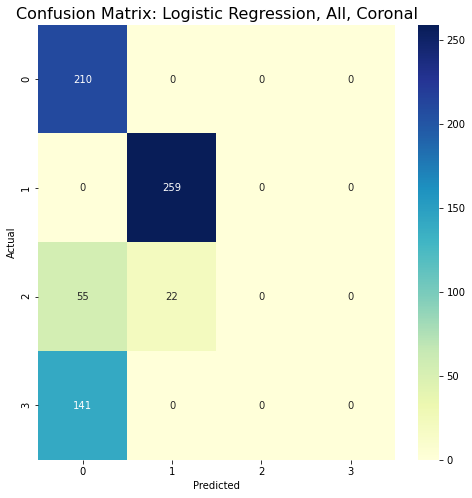

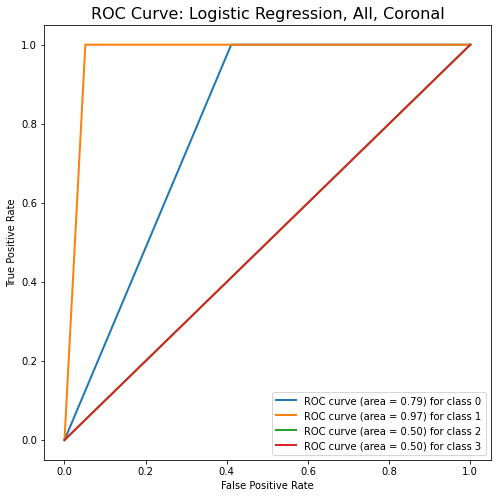

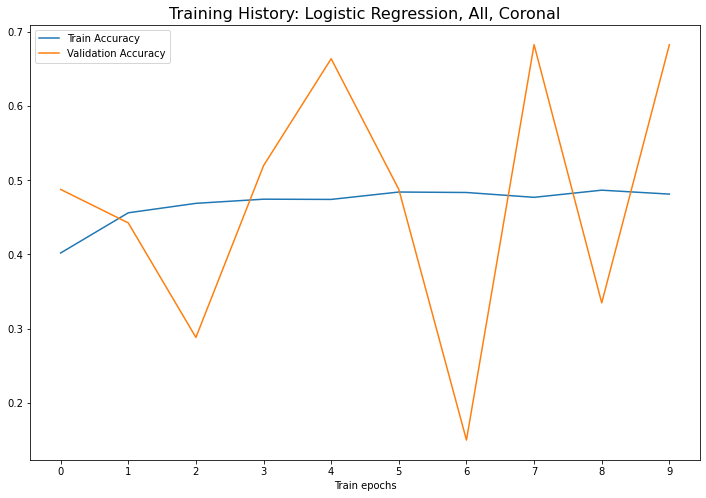

In [119]:
plotConfMatrix(y_val_coronal_shuff, logistic_regression_all_coronal_val_predictions_sparse, logistic_regression_all_coronal_title)
plotROCCurve(y_val_coronal_shuff, logistic_regression_all_coronal_val_predictions, logistic_regression_all_coronal_title)
plotTrainingHistory(history, logistic_regression_all_coronal_title)


In [120]:
logistic_regression_all_coronal_accuracy, logistic_regression_all_coronal_precisions, logistic_regression_all_coronal_recalls = allClassPrecisionsandRecalls(y_val_coronal_shuff.tolist(), logistic_regression_all_coronal_val_predictions_sparse.tolist())


#### Coronal, Scaled

In [121]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

logistic_regression_scaled_coronal = build_multiclass_logistic_regression_model(4, 0.01)
numEpochs = 10

startTime = time.time()
history = logistic_regression_scaled_coronal.fit(
  x = X_train_scaled_coronal,
  y = y_train_coronal_shuff,
  epochs=numEpochs,
  batch_size=32,
  validation_data = (X_val_scaled_coronal, y_val_coronal_shuff),
  verbose=1)
endTime = time.time()

logistic_regression_scaled_coronal_time = (endTime - startTime)/60
logistic_regression_scaled_coronal_title = 'Logistic Regression, Scaled, Coronal'

Epoch 1/10
101/101 [==============================] - 2s 10ms/step - loss: 0.0856 - accuracy: 0.9704 - recall_c1: 0.9660 - precision_c1: 0.9728 - recall_c2: 0.9851 - precision_c2: 0.9804 - recall_c3: 0.9188 - precision_c3: 0.9205 - recall_c4: 0.9655 - precision_c4: 0.9646 - val_loss: 1.4109 - val_accuracy: 0.6390 - val_recall_c1: 0.7390 - val_precision_c1: 0.7444 - val_recall_c2: 0.8623 - val_precision_c2: 0.6949 - val_recall_c3: 0.5052 - val_precision_c3: 0.4211 - val_recall_c4: 0.1323 - val_precision_c4: 0.2750
Epoch 2/10
101/101 [==============================] - 0s 3ms/step - loss: 0.0044 - accuracy: 1.0000 - recall_c1: 1.0000 - precision_c1: 1.0000 - recall_c2: 1.0000 - precision_c2: 1.0000 - recall_c3: 0.9505 - precision_c3: 0.9505 - recall_c4: 1.0000 - precision_c4: 1.0000 - val_loss: 1.4633 - val_accuracy: 0.6434 - val_recall_c1: 0.7431 - val_precision_c1: 0.7452 - val_recall_c2: 0.8747 - val_precision_c2: 0.6985 - val_recall_c3: 0.4938 - val_precision_c3: 0.4271 - val_recall_c

In [122]:
logistic_regression_scaled_coronal_val_predictions = logistic_regression_scaled_coronal.predict(X_val_scaled_coronal)
logistic_regression_scaled_coronal_val_predictions_sparse = np.argmax(logistic_regression_scaled_coronal_val_predictions, axis=-1)


22/22 [==============================] - 0s 1ms/step


In [123]:
print(classification_report(y_val_coronal_shuff, logistic_regression_scaled_coronal_val_predictions_sparse))


              precision    recall  f1-score   support

           0       0.73      0.76      0.74       210
           1       0.71      0.91      0.80       259
           2       0.47      0.51      0.49        77
           3       0.34      0.13      0.19       141

    accuracy                           0.66       687
   macro avg       0.56      0.58      0.56       687
weighted avg       0.61      0.66      0.62       687



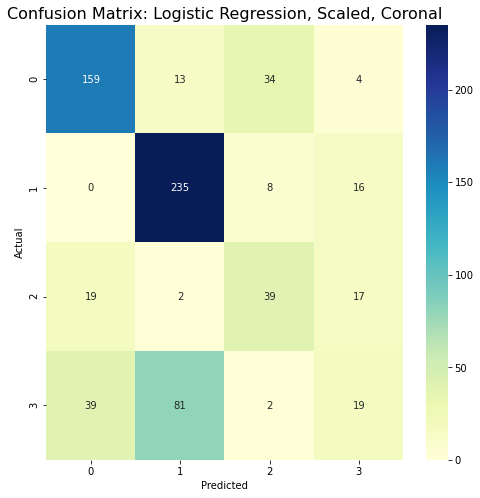

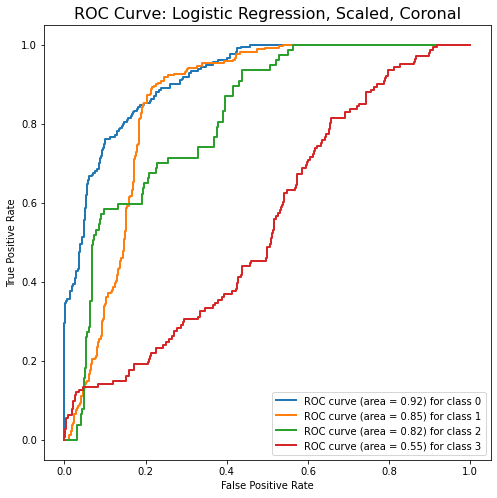

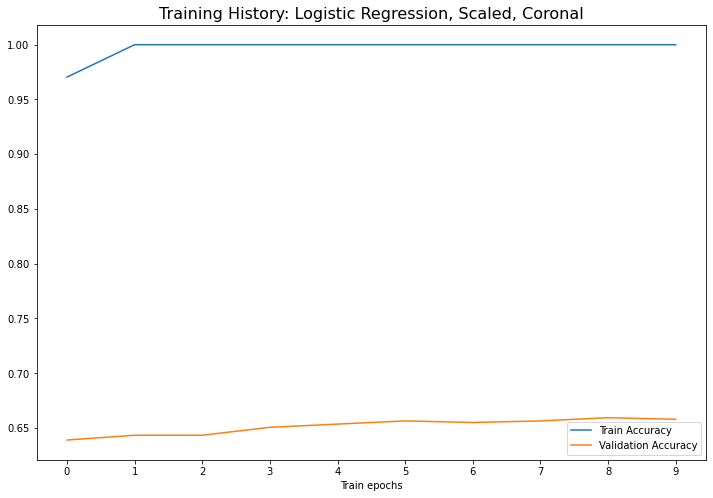

In [124]:
plotConfMatrix(y_val_coronal_shuff, logistic_regression_scaled_coronal_val_predictions_sparse, logistic_regression_scaled_coronal_title)
plotROCCurve(y_val_coronal_shuff, logistic_regression_scaled_coronal_val_predictions, logistic_regression_scaled_coronal_title)
plotTrainingHistory(history, logistic_regression_scaled_coronal_title)


In [125]:
logistic_regression_scaled_coronal_accuracy, logistic_regression_scaled_coronal_precisions, logistic_regression_scaled_coronal_recalls = allClassPrecisionsandRecalls(y_val_coronal_shuff.tolist(), logistic_regression_scaled_coronal_val_predictions_sparse.tolist())


#### Coronal, PCA

In [126]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

logistic_regression_pca_coronal = build_multiclass_logistic_regression_model(4, 0.01)
numEpochs = 10

startTime = time.time()
history = logistic_regression_pca_coronal.fit(
  x = X_train_pca_coronal,
  y = y_train_coronal_shuff,
  epochs=numEpochs,
  batch_size=32,
  validation_data = (X_val_pca_coronal, y_val_coronal_shuff),
  verbose=1)
endTime = time.time()

logistic_regression_pca_coronal_time = (endTime - startTime)/60
logistic_regression_pca_coronal_title = 'Logistic Regression, PCA, Coronal'

Epoch 1/10
101/101 [==============================] - 1s 4ms/step - loss: 0.5737 - accuracy: 0.9191 - recall_c1: 0.9283 - precision_c1: 0.9700 - recall_c2: 0.9280 - precision_c2: 0.9270 - recall_c3: 0.8492 - precision_c3: 0.8205 - recall_c4: 0.9185 - precision_c4: 0.8985 - val_loss: 2.6412 - val_accuracy: 0.5808 - val_recall_c1: 0.7322 - val_precision_c1: 0.6307 - val_recall_c2: 0.7976 - val_precision_c2: 0.6662 - val_recall_c3: 0.2509 - val_precision_c3: 0.1640 - val_recall_c4: 0.1474 - val_precision_c4: 0.4131
Epoch 2/10
101/101 [==============================] - 1s 11ms/step - loss: 0.0058 - accuracy: 0.9997 - recall_c1: 1.0000 - precision_c1: 0.9988 - recall_c2: 1.0000 - precision_c2: 1.0000 - recall_c3: 0.9485 - precision_c3: 0.9505 - recall_c4: 1.0000 - precision_c4: 1.0000 - val_loss: 2.5663 - val_accuracy: 0.6114 - val_recall_c1: 0.7367 - val_precision_c1: 0.6265 - val_recall_c2: 0.8727 - val_precision_c2: 0.6940 - val_recall_c3: 0.2751 - val_precision_c3: 0.2167 - val_recall_c

22/22 [==============================] - 0s 719us/step
              precision    recall  f1-score   support

           0       0.65      0.73      0.69       210
           1       0.69      0.90      0.79       259
           2       0.27      0.27      0.27        77
           3       0.60      0.15      0.24       141

    accuracy                           0.63       687
   macro avg       0.55      0.51      0.50       687
weighted avg       0.61      0.63      0.59       687



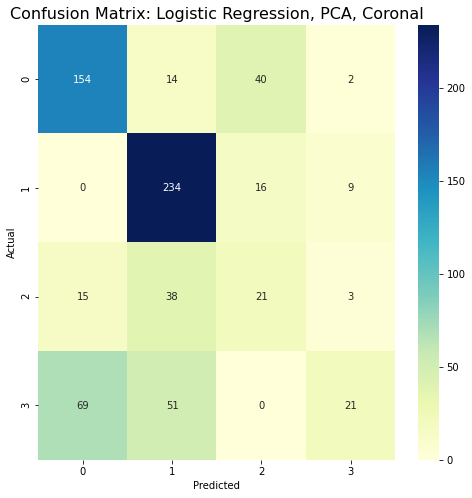

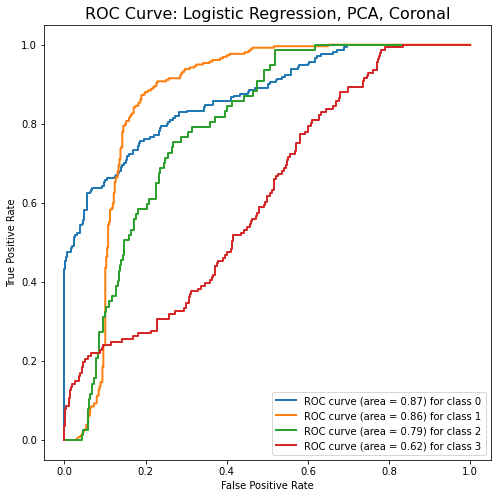

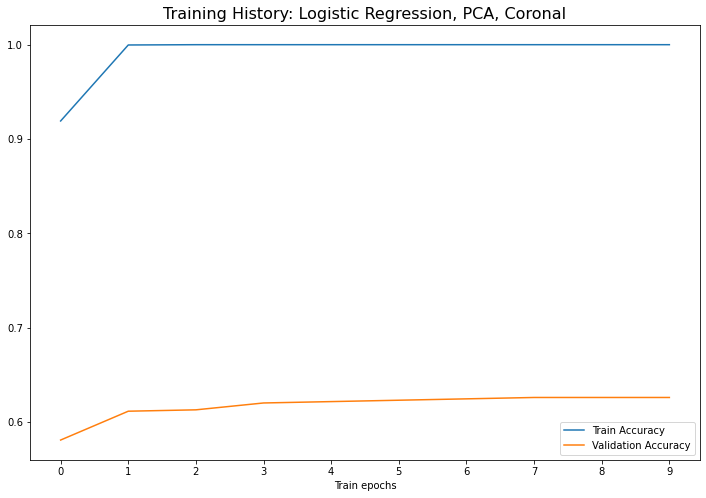

In [127]:
logistic_regression_pca_coronal_val_predictions = logistic_regression_pca_coronal.predict(X_val_pca_coronal)
logistic_regression_pca_coronal_val_predictions_sparse = np.argmax(logistic_regression_pca_coronal_val_predictions, axis=-1)

print(classification_report(y_val_coronal_shuff, logistic_regression_pca_coronal_val_predictions_sparse))

plotConfMatrix(y_val_coronal_shuff, logistic_regression_pca_coronal_val_predictions_sparse, logistic_regression_pca_coronal_title)
plotROCCurve(y_val_coronal_shuff, logistic_regression_pca_coronal_val_predictions, logistic_regression_pca_coronal_title)
plotTrainingHistory(history, logistic_regression_pca_coronal_title)

logistic_regression_pca_coronal_accuracy, logistic_regression_pca_coronal_precisions, logistic_regression_pca_coronal_recalls = allClassPrecisionsandRecalls(y_val_coronal_shuff.tolist(), logistic_regression_pca_coronal_val_predictions_sparse.tolist())



#### Axial, All, Unscaled

In [128]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

logistic_regression_all_axial = build_multiclass_logistic_regression_model(4, 0.01)
numEpochs = 15

startTime = time.time()
history = logistic_regression_all_axial.fit(
  x = X_train_all_axial,
  y = y_train_axial_shuff,
  epochs=numEpochs,
  batch_size=32,
  validation_data = (X_val_all_axial, y_val_axial_shuff),
  verbose=1)
endTime = time.time()

logistic_regression_all_axial_time = (endTime - startTime)/60
logistic_regression_all_axial_title = 'Logistic Regression, All, Axial'

Epoch 1/15
161/161 [==============================] - 2s 7ms/step - loss: 4825166.0000 - accuracy: 0.3823 - recall_c1: 0.3888 - precision_c1: 0.3299 - recall_c2: 0.5264 - precision_c2: 0.4396 - recall_c3: 0.1147 - precision_c3: 0.0219 - recall_c4: 0.1809 - precision_c4: 0.0476 - val_loss: 2489848.0000 - val_accuracy: 0.4291 - val_recall_c1: 0.0000e+00 - val_precision_c1: 0.0000e+00 - val_recall_c2: 0.5426 - val_precision_c2: 0.7954 - val_recall_c3: 0.0000e+00 - val_precision_c3: 0.0000e+00 - val_recall_c4: 1.0000 - val_precision_c4: 0.2710
Epoch 2/15
161/161 [==============================] - 0s 2ms/step - loss: 4025906.2500 - accuracy: 0.4228 - recall_c1: 0.4570 - precision_c1: 0.3894 - recall_c2: 0.5808 - precision_c2: 0.4794 - recall_c3: 0.1178 - precision_c3: 0.0342 - recall_c4: 0.2004 - precision_c4: 0.0682 - val_loss: 4590019.0000 - val_accuracy: 0.1827 - val_recall_c1: 0.0000e+00 - val_precision_c1: 0.0000e+00 - val_recall_c2: 0.0000e+00 - val_precision_c2: 0.0000e+00 - val_reca

In [129]:
logistic_regression_all_axial_val_predictions = logistic_regression_all_axial.predict(X_val_all_axial)
logistic_regression_all_axial_val_predictions_sparse = np.argmax(logistic_regression_all_axial_val_predictions, axis=-1)

print(classification_report(y_val_axial_shuff, logistic_regression_all_axial_val_predictions_sparse))



logistic_regression_all_axial_accuracy, logistic_regression_all_axial_precisions, logistic_regression_all_axial_recalls = allClassPrecisionsandRecalls(y_val_axial_shuff.tolist(), logistic_regression_all_axial_val_predictions_sparse.tolist())


35/35 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       1.00      0.06      0.11       282
           1       1.00      0.07      0.12       491
           2       1.00      0.67      0.81       126
           3       0.21      1.00      0.34       201

    accuracy                           0.30      1100
   macro avg       0.80      0.45      0.35      1100
weighted avg       0.86      0.30      0.24      1100



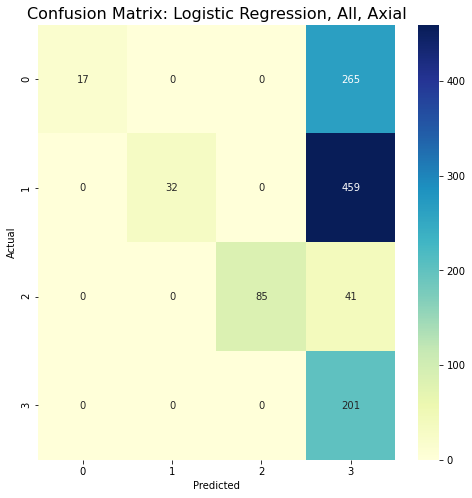

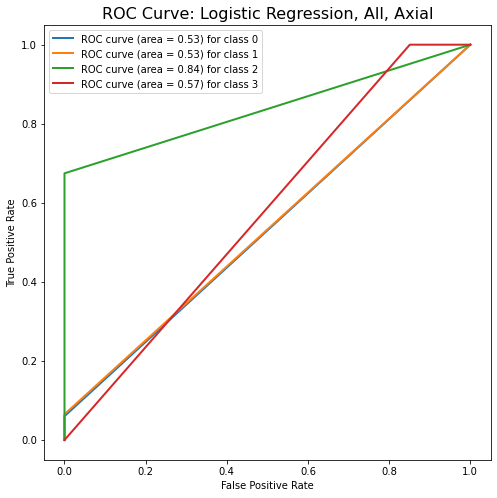

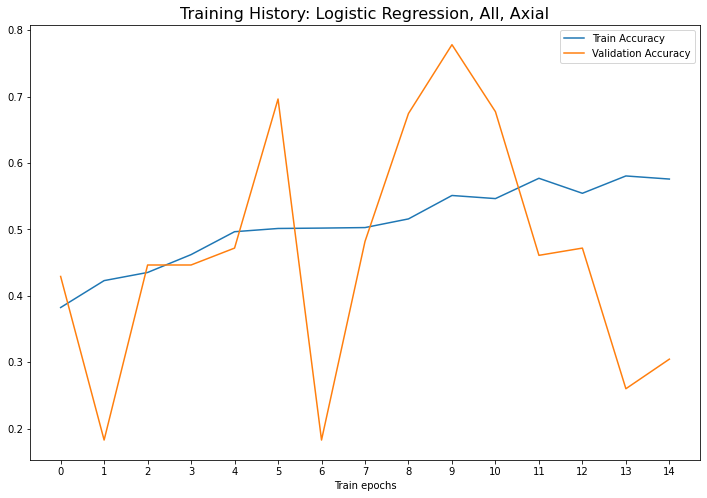

In [130]:
plotConfMatrix(y_val_axial_shuff, logistic_regression_all_axial_val_predictions_sparse, logistic_regression_all_axial_title)
plotROCCurve(y_val_axial_shuff, logistic_regression_all_axial_val_predictions, logistic_regression_all_axial_title)
plotTrainingHistory(history, logistic_regression_all_axial_title)

#### Axial, Scaled

In [131]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

logistic_regression_scaled_axial = build_multiclass_logistic_regression_model(4, 0.01)
numEpochs = 15

startTime = time.time()
history = logistic_regression_scaled_axial.fit(
  x = X_train_scaled_axial,
  y = y_train_axial_shuff,
  epochs=numEpochs,
  batch_size=32,
  validation_data = (X_val_scaled_axial, y_val_axial_shuff),
  verbose=1)
endTime = time.time()

logistic_regression_scaled_axial_time = (endTime - startTime)/60
logistic_regression_scaled_axial_title = 'Logistic Regression, Scaled, Axial'

Epoch 1/15
161/161 [==============================] - 2s 7ms/step - loss: 0.0823 - accuracy: 0.9770 - recall_c1: 0.9735 - precision_c1: 0.9799 - recall_c2: 0.9875 - precision_c2: 0.9858 - recall_c3: 0.9158 - precision_c3: 0.9264 - recall_c4: 0.9747 - precision_c4: 0.9726 - val_loss: 3.8839 - val_accuracy: 0.2573 - val_recall_c1: 0.1508 - val_precision_c1: 0.2236 - val_recall_c2: 0.2745 - val_precision_c2: 0.5820 - val_recall_c3: 0.1979 - val_precision_c3: 0.1256 - val_recall_c4: 0.4339 - val_precision_c4: 0.1493
Epoch 2/15
161/161 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 1.0000 - recall_c1: 1.0000 - precision_c1: 1.0000 - recall_c2: 1.0000 - precision_c2: 1.0000 - recall_c3: 0.9752 - precision_c3: 0.9752 - recall_c4: 1.0000 - precision_c4: 1.0000 - val_loss: 3.9009 - val_accuracy: 0.2809 - val_recall_c1: 0.1653 - val_precision_c1: 0.2562 - val_recall_c2: 0.2801 - val_precision_c2: 0.5768 - val_recall_c3: 0.1979 - val_precision_c3: 0.1342 - val_recall_c4

In [132]:
logistic_regression_scaled_axial_val_predictions = logistic_regression_scaled_axial.predict(X_val_scaled_axial)
logistic_regression_scaled_axial_val_predictions_sparse = np.argmax(logistic_regression_scaled_axial_val_predictions, axis=-1)


35/35 [==============================] - 0s 1ms/step


In [133]:
print(classification_report(y_val_axial_shuff, logistic_regression_scaled_axial_val_predictions_sparse))

              precision    recall  f1-score   support

           0       0.37      0.20      0.26       282
           1       0.67      0.32      0.43       491
           2       0.20      0.21      0.20       126
           3       0.28      0.81      0.41       201

    accuracy                           0.36      1100
   macro avg       0.38      0.38      0.33      1100
weighted avg       0.47      0.36      0.36      1100



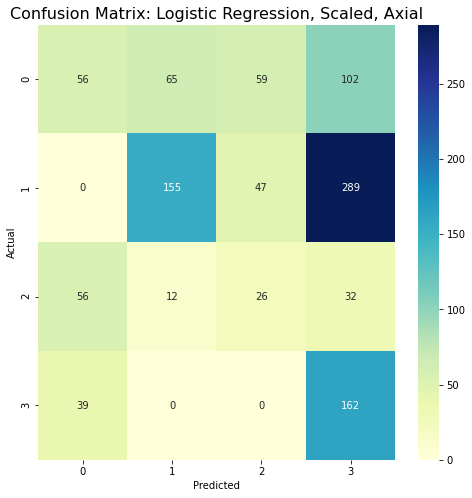

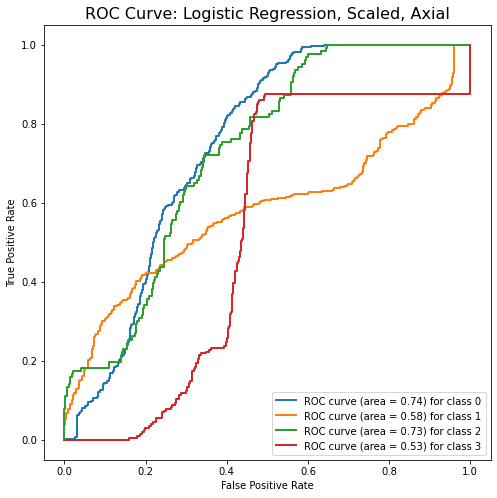

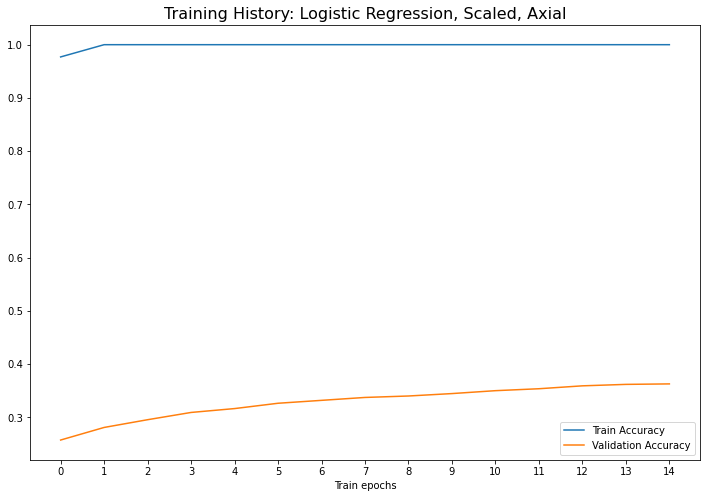

In [134]:
plotConfMatrix(y_val_axial_shuff, logistic_regression_scaled_axial_val_predictions_sparse, logistic_regression_scaled_axial_title)
plotROCCurve(y_val_axial_shuff, logistic_regression_scaled_axial_val_predictions, logistic_regression_scaled_axial_title)
plotTrainingHistory(history, logistic_regression_scaled_axial_title)


In [135]:
logistic_regression_scaled_axial_accuracy, logistic_regression_scaled_axial_precisions, logistic_regression_scaled_axial_recalls = allClassPrecisionsandRecalls(y_val_axial_shuff.tolist(), logistic_regression_scaled_axial_val_predictions_sparse.tolist())


#### Axial, PCA

In [136]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

logistic_regression_pca_axial = build_multiclass_logistic_regression_model(4, 0.01)
numEpochs = 10

startTime = time.time()
history = logistic_regression_pca_axial.fit(
  x = X_train_pca_axial,
  y = y_train_axial_shuff,
  epochs=numEpochs,
  batch_size=32,
  validation_data = (X_val_pca_axial, y_val_axial_shuff),
  verbose=1)
endTime = time.time()

logistic_regression_pca_axial_time = (endTime - startTime)/60
logistic_regression_pca_axial_title = 'Logistic Regression, PCA, Axial'

Epoch 1/10
161/161 [==============================] - 1s 3ms/step - loss: 0.3512 - accuracy: 0.9451 - recall_c1: 0.9390 - precision_c1: 0.9474 - recall_c2: 0.9552 - precision_c2: 0.9734 - recall_c3: 0.8598 - precision_c3: 0.8504 - recall_c4: 0.9566 - precision_c4: 0.9336 - val_loss: 6.9535 - val_accuracy: 0.2800 - val_recall_c1: 0.5538 - val_precision_c1: 0.4009 - val_recall_c2: 0.2061 - val_precision_c2: 0.5646 - val_recall_c3: 0.0824 - val_precision_c3: 0.0760 - val_recall_c4: 0.2437 - val_precision_c4: 0.0907
Epoch 2/10
161/161 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 1.0000 - recall_c1: 1.0000 - precision_c1: 1.0000 - recall_c2: 1.0000 - precision_c2: 1.0000 - recall_c3: 0.9752 - precision_c3: 0.9752 - recall_c4: 1.0000 - precision_c4: 1.0000 - val_loss: 7.1329 - val_accuracy: 0.2773 - val_recall_c1: 0.5163 - val_precision_c1: 0.3989 - val_recall_c2: 0.2083 - val_precision_c2: 0.5509 - val_recall_c3: 0.0976 - val_precision_c3: 0.0912 - val_recall_c4

In [137]:
logistic_regression_pca_axial_val_predictions = logistic_regression_pca_axial.predict(X_val_pca_axial)
logistic_regression_pca_axial_val_predictions_sparse = np.argmax(logistic_regression_pca_axial_val_predictions, axis=-1)


35/35 [==============================] - 0s 588us/step


In [138]:
print(classification_report(y_val_axial_shuff, logistic_regression_pca_axial_val_predictions_sparse))

              precision    recall  f1-score   support

           0       0.39      0.49      0.44       282
           1       0.59      0.22      0.32       491
           2       0.13      0.13      0.13       126
           3       0.11      0.23      0.15       201

    accuracy                           0.28      1100
   macro avg       0.31      0.27      0.26      1100
weighted avg       0.40      0.28      0.30      1100



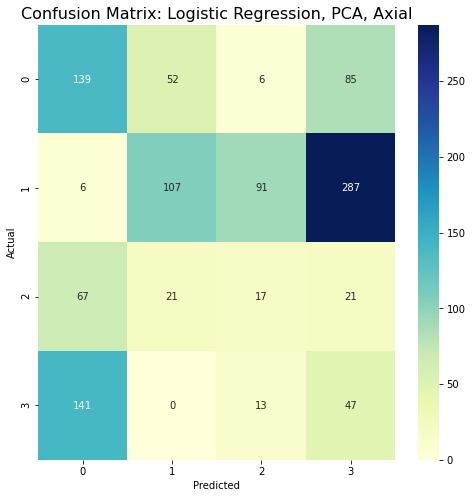

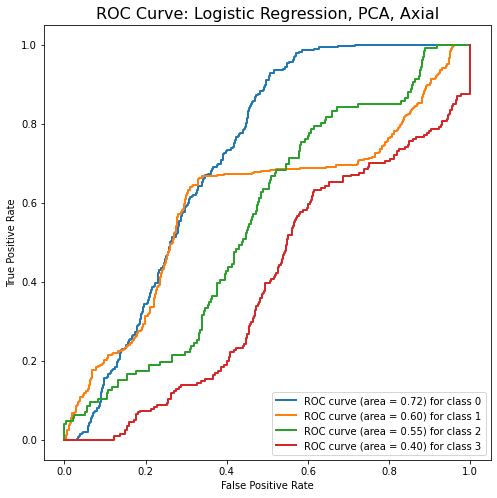

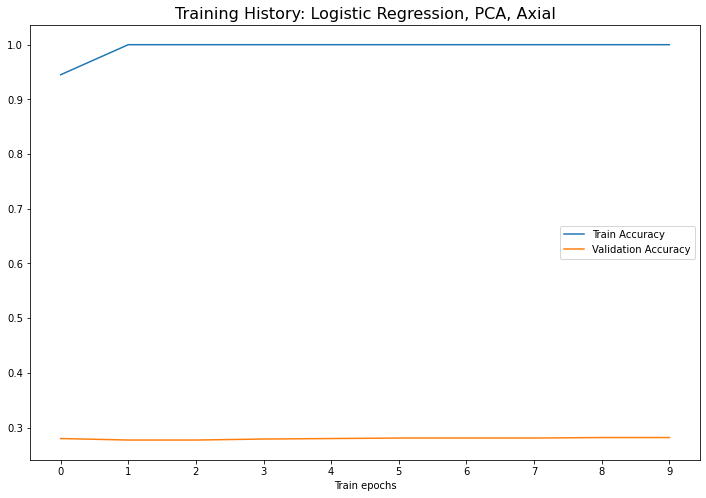

In [139]:
plotConfMatrix(y_val_axial_shuff, logistic_regression_pca_axial_val_predictions_sparse, logistic_regression_pca_axial_title)
plotROCCurve(y_val_axial_shuff, logistic_regression_pca_axial_val_predictions, logistic_regression_pca_axial_title)
plotTrainingHistory(history, logistic_regression_pca_axial_title)

In [140]:
logistic_regression_pca_axial_accuracy, logistic_regression_pca_axial_precisions, logistic_regression_pca_axial_recalls = allClassPrecisionsandRecalls(y_val_axial_shuff.tolist(), logistic_regression_pca_axial_val_predictions_sparse.tolist())


### Neural Network: 1 Hidden Layer

#### Coronal, All, Unscaled

In [141]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

neural_net_all_coronal = build_multiclass_simple_perceptron_model(4, 0.01)
numEpochs = 10

startTime = time.time()
history = neural_net_all_coronal.fit(
  x = X_train_all_coronal,
  y = y_train_coronal_shuff,
  epochs=numEpochs,
  batch_size=32,
  validation_data = (X_val_all_coronal, y_val_coronal_shuff),
  verbose=1)
endTime = time.time()

neural_net_all_coronal_time = (endTime - startTime)/60
neural_net_all_coronal_title = 'Neural Net, All, Coronal'

Epoch 1/10
101/101 [==============================] - 3s 19ms/step - loss: 245.2317 - accuracy: 0.4300 - recall_c1: 0.7373 - precision_c1: 0.4377 - recall_c2: 0.3981 - precision_c2: 0.6994 - recall_c3: 0.1836 - precision_c3: 0.2911 - recall_c4: 0.1861 - precision_c4: 0.0618 - val_loss: 1.1494 - val_accuracy: 0.4876 - val_recall_c1: 1.0000 - val_precision_c1: 0.3693 - val_recall_c2: 0.4878 - val_precision_c2: 1.0000 - val_recall_c3: 0.0000e+00 - val_precision_c3: 0.0000e+00 - val_recall_c4: 0.0000e+00 - val_precision_c4: 0.0000e+00
Epoch 2/10
101/101 [==============================] - 1s 13ms/step - loss: 1.3503 - accuracy: 0.3703 - recall_c1: 0.7723 - precision_c1: 0.2644 - recall_c2: 0.3533 - precision_c2: 0.3784 - recall_c3: 0.0531 - precision_c3: 0.1213 - recall_c4: 0.0000e+00 - precision_c4: 0.0000e+00 - val_loss: 1.3039 - val_accuracy: 0.3770 - val_recall_c1: 0.0000e+00 - val_precision_c1: 0.0000e+00 - val_recall_c2: 1.0000 - val_precision_c2: 0.3759 - val_recall_c3: 0.0000e+00 - 

In [142]:
neural_net_all_coronal_val_predictions = neural_net_all_coronal.predict(X_val_all_coronal)
neural_net_all_coronal_val_predictions_sparse = np.argmax(neural_net_all_coronal_val_predictions, axis=-1)


22/22 [==============================] - 0s 2ms/step


In [143]:
print(classification_report(y_val_coronal_shuff, neural_net_all_coronal_val_predictions_sparse))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       210
           1       0.38      1.00      0.55       259
           2       0.00      0.00      0.00        77
           3       0.00      0.00      0.00       141

    accuracy                           0.38       687
   macro avg       0.09      0.25      0.14       687
weighted avg       0.14      0.38      0.21       687



/Users/karachristensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karachristensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karachristensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

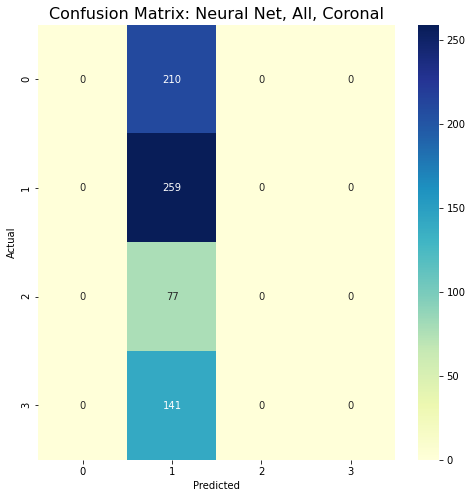

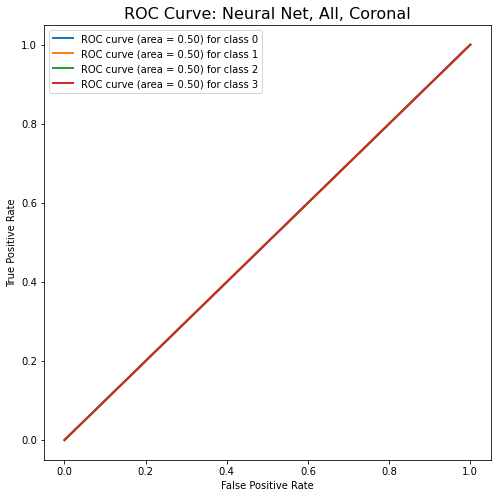

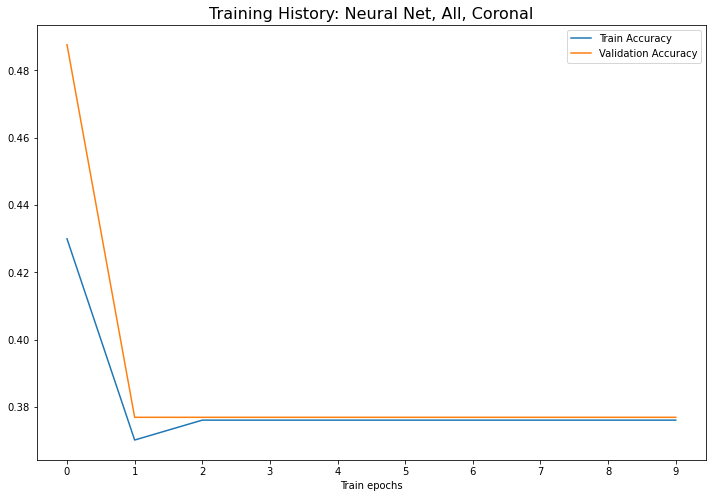

In [144]:
plotConfMatrix(y_val_coronal_shuff, neural_net_all_coronal_val_predictions_sparse, neural_net_all_coronal_title)
plotROCCurve(y_val_coronal_shuff, neural_net_all_coronal_val_predictions, neural_net_all_coronal_title)
plotTrainingHistory(history, neural_net_all_coronal_title)


In [145]:

neural_net_all_coronal_accuracy, neural_net_all_coronal_precisions, neural_net_all_coronal_recalls = allClassPrecisionsandRecalls(y_val_coronal_shuff.tolist(), neural_net_all_coronal_val_predictions_sparse.tolist())


#### Coronal, Scaled

In [146]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

neural_net_scaled_coronal = build_multiclass_simple_perceptron_model(4, 0.01)
numEpochs = 10

startTime = time.time()
history = neural_net_scaled_coronal.fit(
  x = X_train_scaled_coronal,
  y = y_train_coronal_shuff,
  epochs=numEpochs,
  batch_size=32,
  validation_data = (X_val_scaled_coronal, y_val_coronal_shuff),
  verbose=1)
endTime = time.time()

neural_net_scaled_coronal_time = (endTime - startTime)/60
neural_net_scaled_coronal_title = 'Neural Net, Scaled, Coronal'

Epoch 1/10
101/101 [==============================] - 2s 17ms/step - loss: 3.6611 - accuracy: 0.9527 - recall_c1: 0.9542 - precision_c1: 0.9644 - recall_c2: 0.9680 - precision_c2: 0.9657 - recall_c3: 0.8802 - precision_c3: 0.8787 - recall_c4: 0.9455 - precision_c4: 0.9531 - val_loss: 39.9302 - val_accuracy: 0.6186 - val_recall_c1: 0.7975 - val_precision_c1: 0.7284 - val_recall_c2: 0.7091 - val_precision_c2: 0.7045 - val_recall_c3: 0.6685 - val_precision_c3: 0.3875 - val_recall_c4: 0.1728 - val_precision_c4: 0.3379
Epoch 2/10
101/101 [==============================] - 1s 12ms/step - loss: 0.6264 - accuracy: 0.9904 - recall_c1: 0.9946 - precision_c1: 0.9921 - recall_c2: 0.9941 - precision_c2: 0.9947 - recall_c3: 0.9283 - precision_c3: 0.9330 - recall_c4: 0.9903 - precision_c4: 0.9900 - val_loss: 151.9982 - val_accuracy: 0.5852 - val_recall_c1: 0.6461 - val_precision_c1: 0.6145 - val_recall_c2: 0.8466 - val_precision_c2: 0.6474 - val_recall_c3: 0.1277 - val_precision_c3: 0.1455 - val_reca

In [147]:
neural_net_scaled_coronal_val_predictions = neural_net_scaled_coronal.predict(X_val_scaled_coronal)
neural_net_scaled_coronal_val_predictions_sparse = np.argmax(neural_net_scaled_coronal_val_predictions, axis=-1)

print(classification_report(y_val_coronal_shuff, neural_net_scaled_coronal_val_predictions_sparse))

neural_net_scaled_coronal_accuracy, neural_net_scaled_coronal_precisions, neural_net_scaled_coronal_recalls = allClassPrecisionsandRecalls(y_val_coronal_shuff.tolist(), neural_net_scaled_coronal_val_predictions_sparse.tolist())


22/22 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.59      0.77      0.67       210
           1       0.69      0.78      0.73       259
           2       0.14      0.14      0.14        77
           3       0.34      0.09      0.15       141

    accuracy                           0.56       687
   macro avg       0.44      0.45      0.42       687
weighted avg       0.52      0.56      0.52       687



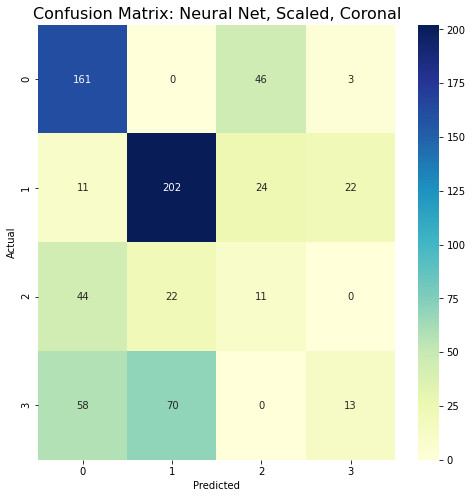

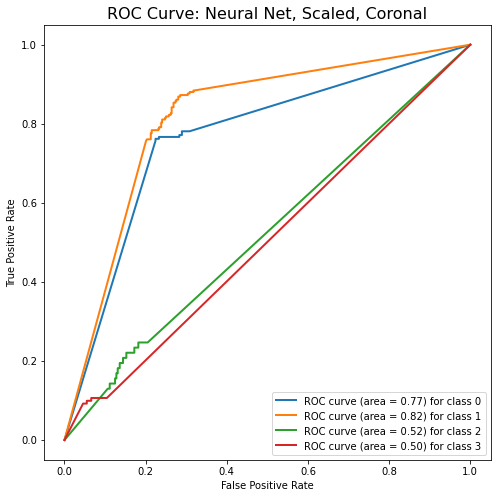

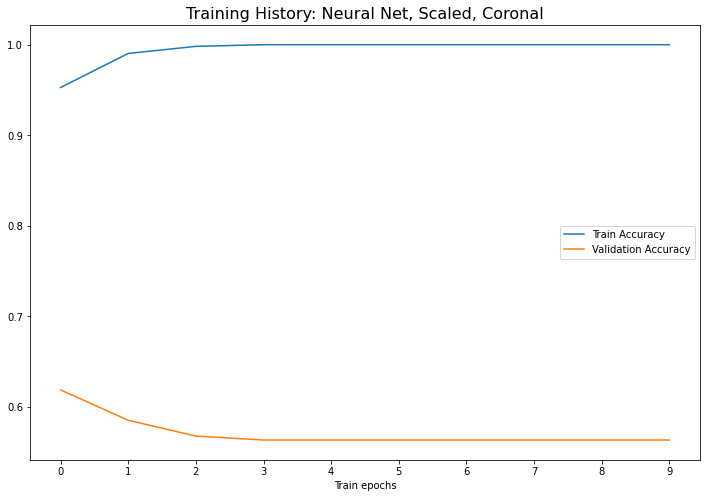

In [148]:
plotConfMatrix(y_val_coronal_shuff, neural_net_scaled_coronal_val_predictions_sparse, neural_net_scaled_coronal_title)
plotROCCurve(y_val_coronal_shuff, neural_net_scaled_coronal_val_predictions, neural_net_scaled_coronal_title)
plotTrainingHistory(history, neural_net_scaled_coronal_title)


#### Coronal PCA

In [149]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

neural_net_pca_coronal = build_multiclass_simple_perceptron_model(4, 0.01)
numEpochs = 10

startTime = time.time()
history = neural_net_pca_coronal.fit(
  x = X_train_pca_coronal,
  y = y_train_coronal_shuff,
  epochs=numEpochs,
  batch_size=32,
  validation_data = (X_val_pca_coronal, y_val_coronal_shuff),
  verbose=1)
endTime = time.time()

neural_net_pca_coronal_time = (endTime - startTime)/60
neural_net_pca_coronal_title = 'Neural Net, PCA, Coronal'

Epoch 1/10
101/101 [==============================] - 1s 4ms/step - loss: 0.3986 - accuracy: 0.9561 - recall_c1: 0.9658 - precision_c1: 0.9615 - recall_c2: 0.9646 - precision_c2: 0.9658 - recall_c3: 0.8999 - precision_c3: 0.8884 - recall_c4: 0.9460 - precision_c4: 0.9551 - val_loss: 10.3366 - val_accuracy: 0.5313 - val_recall_c1: 0.5188 - val_precision_c1: 0.5875 - val_recall_c2: 0.8499 - val_precision_c2: 0.6328 - val_recall_c3: 0.2271 - val_precision_c3: 0.2029 - val_recall_c4: 0.1285 - val_precision_c4: 0.2773
Epoch 2/10
101/101 [==============================] - 0s 2ms/step - loss: 0.0059 - accuracy: 0.9991 - recall_c1: 0.9982 - precision_c1: 0.9988 - recall_c2: 1.0000 - precision_c2: 1.0000 - recall_c3: 0.9485 - precision_c3: 0.9464 - recall_c4: 1.0000 - precision_c4: 1.0000 - val_loss: 10.2742 - val_accuracy: 0.6070 - val_recall_c1: 0.8173 - val_precision_c1: 0.6846 - val_recall_c2: 0.7909 - val_precision_c2: 0.6716 - val_recall_c3: 0.2088 - val_precision_c3: 0.2633 - val_recall_

22/22 [==============================] - 0s 680us/step
              precision    recall  f1-score   support

           0       0.68      0.81      0.74       210
           1       0.66      0.79      0.72       259
           2       0.25      0.19      0.22        77
           3       0.39      0.18      0.25       141

    accuracy                           0.61       687
   macro avg       0.50      0.50      0.48       687
weighted avg       0.57      0.61      0.57       687



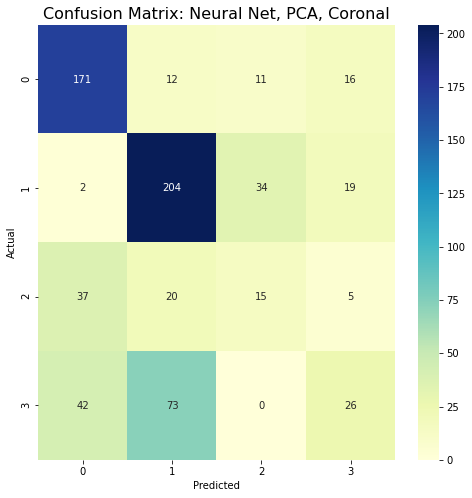

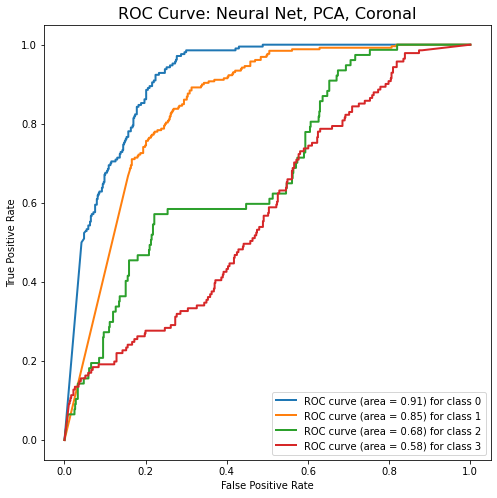

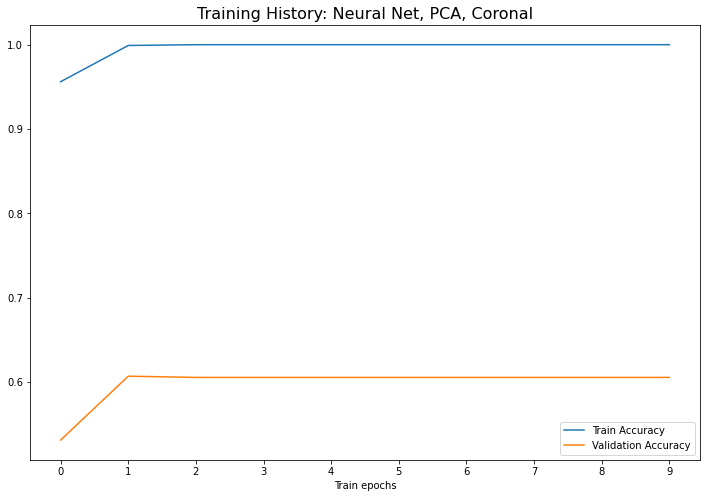

In [150]:
neural_net_pca_coronal_val_predictions = neural_net_pca_coronal.predict(X_val_pca_coronal)
neural_net_pca_coronal_val_predictions_sparse = np.argmax(neural_net_pca_coronal_val_predictions, axis=-1)

print(classification_report(y_val_coronal_shuff, neural_net_pca_coronal_val_predictions_sparse))

plotConfMatrix(y_val_coronal_shuff, neural_net_pca_coronal_val_predictions_sparse, neural_net_pca_coronal_title)
plotROCCurve(y_val_coronal_shuff, neural_net_pca_coronal_val_predictions, neural_net_pca_coronal_title)
plotTrainingHistory(history, neural_net_pca_coronal_title)

neural_net_pca_coronal_accuracy, neural_net_pca_coronal_precisions, neural_net_pca_coronal_recalls = allClassPrecisionsandRecalls(y_val_coronal_shuff.tolist(), neural_net_pca_coronal_val_predictions_sparse.tolist())



#### Axial, All, Unscaled

In [151]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

neural_net_all_axial = build_multiclass_simple_perceptron_model(4, 0.01)
numEpochs = 10

startTime = time.time()
history = neural_net_all_axial.fit(
  x = X_train_all_axial,
  y = y_train_axial_shuff,
  epochs=numEpochs,
  batch_size=32,
  validation_data = (X_val_all_axial, y_val_axial_shuff),
  verbose=1)
endTime = time.time()

neural_net_all_axial_time = (endTime - startTime)/60
neural_net_all_axial_title = 'Neural Net, All, Axial'

Epoch 1/10
161/161 [==============================] - 3s 14ms/step - loss: 95.1472 - accuracy: 0.6302 - recall_c1: 0.7447 - precision_c1: 0.5294 - recall_c2: 0.7397 - precision_c2: 0.8192 - recall_c3: 0.2899 - precision_c3: 0.3455 - recall_c4: 0.3868 - precision_c4: 0.5578 - val_loss: 1.4904 - val_accuracy: 0.4464 - val_recall_c1: 1.0000 - val_precision_c1: 0.3529 - val_recall_c2: 0.4176 - val_precision_c2: 1.0000 - val_recall_c3: 0.0000e+00 - val_precision_c3: 0.0000e+00 - val_recall_c4: 0.0000e+00 - val_precision_c4: 0.0000e+00
Epoch 2/10
161/161 [==============================] - 2s 11ms/step - loss: 0.6828 - accuracy: 0.7605 - recall_c1: 1.0000 - precision_c1: 0.5491 - recall_c2: 0.8473 - precision_c2: 0.9727 - recall_c3: 0.2549 - precision_c3: 0.5947 - recall_c4: 0.5276 - precision_c4: 0.9129 - val_loss: 1.9906 - val_accuracy: 0.6273 - val_recall_c1: 1.0000 - val_precision_c1: 0.5287 - val_recall_c2: 0.6463 - val_precision_c2: 1.0000 - val_recall_c3: 0.0000e+00 - val_precision_c3:

In [152]:
neural_net_all_axial_val_predictions = neural_net_all_axial.predict(X_val_all_axial)
neural_net_all_axial_val_predictions_sparse = np.argmax(neural_net_all_axial_val_predictions, axis=-1)

print(classification_report(y_val_axial_shuff, neural_net_all_axial_val_predictions_sparse))


neural_net_all_axial_accuracy, neural_net_all_axial_precisions, neural_net_all_axial_recalls = allClassPrecisionsandRecalls(y_val_axial_shuff.tolist(), neural_net_all_axial_val_predictions_sparse.tolist())


35/35 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.33      1.00      0.49       282
           1       1.00      0.48      0.65       491
           2       0.00      0.00      0.00       126
           3       0.00      0.00      0.00       201

    accuracy                           0.47      1100
   macro avg       0.33      0.37      0.28      1100
weighted avg       0.53      0.47      0.41      1100



/Users/karachristensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karachristensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karachristensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

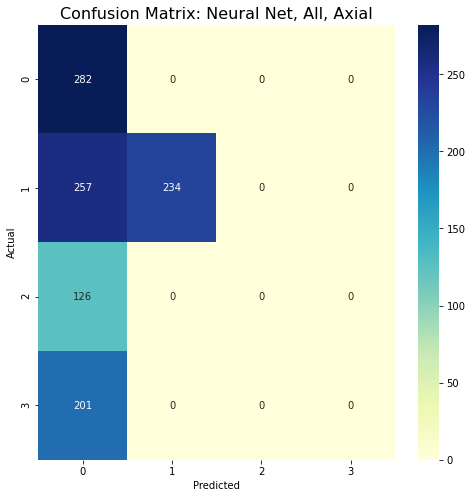

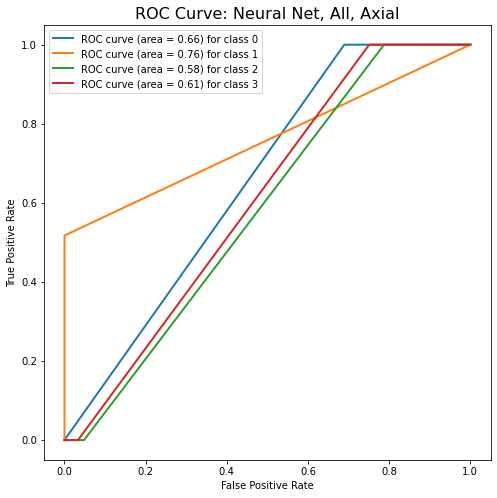

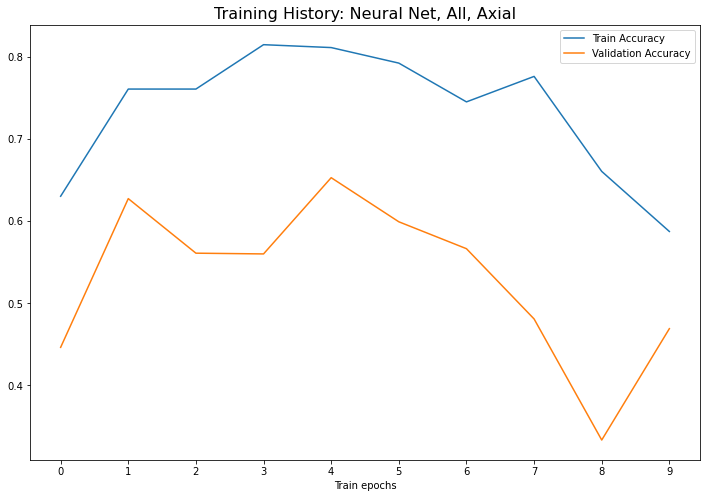

In [153]:
plotConfMatrix(y_val_axial_shuff, neural_net_all_axial_val_predictions_sparse, neural_net_all_axial_title)
plotROCCurve(y_val_axial_shuff, neural_net_all_axial_val_predictions, neural_net_all_axial_title)
plotTrainingHistory(history, neural_net_all_axial_title)

#### Axial, Scaled

In [154]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

neural_net_scaled_axial = build_multiclass_simple_perceptron_model(4, 0.01)
numEpochs = 10

startTime = time.time()
history = neural_net_scaled_axial.fit(
  x = X_train_scaled_axial,
  y = y_train_axial_shuff,
  epochs=numEpochs,
  batch_size=32,
  validation_data = (X_val_scaled_axial, y_val_axial_shuff),
  verbose=1)
endTime = time.time()

neural_net_scaled_axial_time = (endTime - startTime)/60
neural_net_scaled_axial_title = 'Neural Net, Scaled, Axial'

Epoch 1/10
161/161 [==============================] - 3s 14ms/step - loss: 3.3614 - accuracy: 0.9618 - recall_c1: 0.9517 - precision_c1: 0.9521 - recall_c2: 0.9830 - precision_c2: 0.9828 - recall_c3: 0.8759 - precision_c3: 0.9015 - recall_c4: 0.9520 - precision_c4: 0.9578 - val_loss: 90.2300 - val_accuracy: 0.4291 - val_recall_c1: 0.4443 - val_precision_c1: 0.4397 - val_recall_c2: 0.3482 - val_precision_c2: 0.9752 - val_recall_c3: 0.4153 - val_precision_c3: 0.2454 - val_recall_c4: 0.6489 - val_precision_c4: 0.3018
Epoch 2/10
161/161 [==============================] - 2s 12ms/step - loss: 0.1069 - accuracy: 0.9977 - recall_c1: 0.9970 - precision_c1: 0.9974 - recall_c2: 0.9980 - precision_c2: 0.9985 - recall_c3: 0.9727 - precision_c3: 0.9729 - recall_c4: 0.9993 - precision_c4: 0.9984 - val_loss: 101.4282 - val_accuracy: 0.5264 - val_recall_c1: 0.5374 - val_precision_c1: 0.5487 - val_recall_c2: 0.4965 - val_precision_c2: 0.7333 - val_recall_c3: 0.0186 - val_precision_c3: 0.0857 - val_reca

In [155]:
neural_net_scaled_axial_val_predictions = neural_net_scaled_axial.predict(X_val_scaled_axial)
neural_net_scaled_axial_val_predictions_sparse = np.argmax(neural_net_scaled_axial_val_predictions, axis=-1)

print(classification_report(y_val_axial_shuff, neural_net_scaled_axial_val_predictions_sparse))

neural_net_scaled_axial_accuracy, neural_net_scaled_axial_precisions, neural_net_scaled_axial_recalls = allClassPrecisionsandRecalls(y_val_axial_shuff.tolist(), neural_net_scaled_axial_val_predictions_sparse.tolist())


35/35 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       282
           1       0.91      0.52      0.66       491
           2       0.49      0.79      0.61       126
           3       0.44      0.74      0.55       201

    accuracy                           0.69      1100
   macro avg       0.69      0.74      0.68      1100
weighted avg       0.77      0.69      0.70      1100



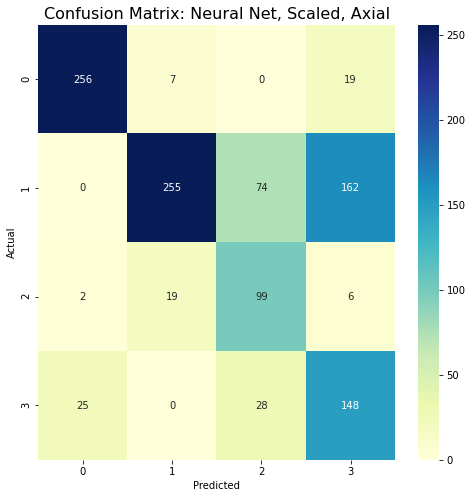

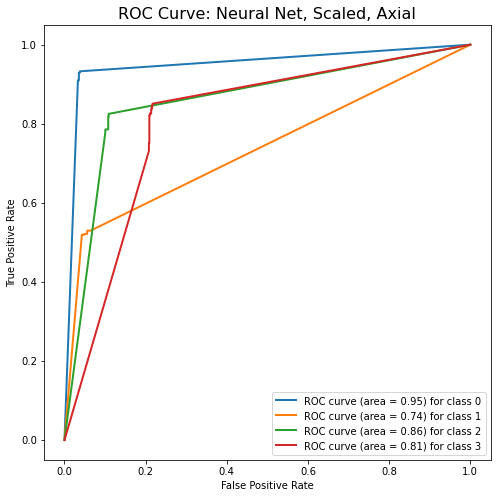

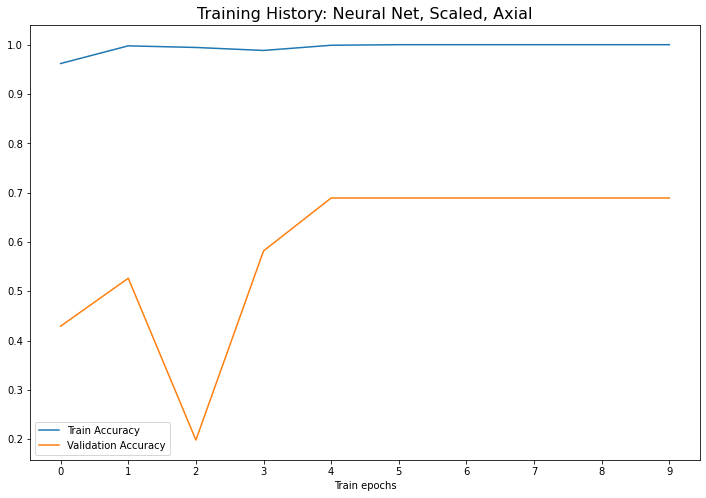

In [156]:
plotConfMatrix(y_val_axial_shuff, neural_net_scaled_axial_val_predictions_sparse, neural_net_scaled_axial_title)
plotROCCurve(y_val_axial_shuff, neural_net_scaled_axial_val_predictions, neural_net_scaled_axial_title)
plotTrainingHistory(history, neural_net_scaled_axial_title)


#### Axial, PCA

In [157]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

neural_net_pca_axial = build_multiclass_simple_perceptron_model(4, 0.01)
numEpochs = 10

startTime = time.time()
history = neural_net_pca_axial.fit(
  x = X_train_pca_axial,
  y = y_train_axial_shuff,
  epochs=numEpochs,
  batch_size=32,
  validation_data = (X_val_pca_axial, y_val_axial_shuff),
  verbose=1)
endTime = time.time()

neural_net_pca_axial_time = (endTime - startTime)/60
neural_net_pca_axial_title = 'Neural Net, PCA, Axial'

Epoch 1/10
161/161 [==============================] - 1s 3ms/step - loss: 0.2731 - accuracy: 0.9737 - recall_c1: 0.9703 - precision_c1: 0.9703 - recall_c2: 0.9848 - precision_c2: 0.9895 - recall_c3: 0.9048 - precision_c3: 0.9077 - recall_c4: 0.9679 - precision_c4: 0.9733 - val_loss: 12.2634 - val_accuracy: 0.4818 - val_recall_c1: 0.6700 - val_precision_c1: 0.7306 - val_recall_c2: 0.2990 - val_precision_c2: 0.8534 - val_recall_c3: 0.1467 - val_precision_c3: 0.1924 - val_recall_c4: 0.8866 - val_precision_c4: 0.2891
Epoch 2/10
161/161 [==============================] - 0s 2ms/step - loss: 0.0229 - accuracy: 0.9996 - recall_c1: 1.0000 - precision_c1: 0.9989 - recall_c2: 1.0000 - precision_c2: 1.0000 - recall_c3: 0.9727 - precision_c3: 0.9752 - recall_c4: 1.0000 - precision_c4: 1.0000 - val_loss: 12.8940 - val_accuracy: 0.3736 - val_recall_c1: 0.2989 - val_precision_c1: 0.6390 - val_recall_c2: 0.2866 - val_precision_c2: 0.7829 - val_recall_c3: 0.1881 - val_precision_c3: 0.0940 - val_recall_

35/35 [==============================] - 0s 804us/step
              precision    recall  f1-score   support

           0       0.72      0.49      0.58       282
           1       0.65      0.16      0.26       491
           2       0.50      0.80      0.62       126
           3       0.28      0.81      0.41       201

    accuracy                           0.44      1100
   macro avg       0.54      0.56      0.47      1100
weighted avg       0.58      0.44      0.41      1100



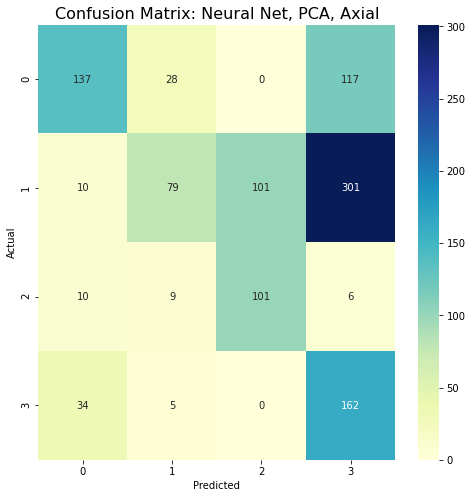

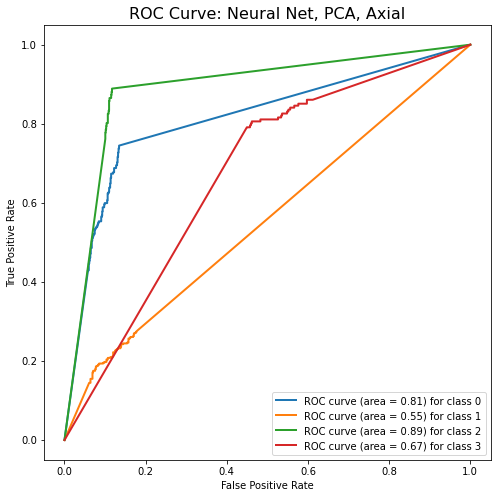

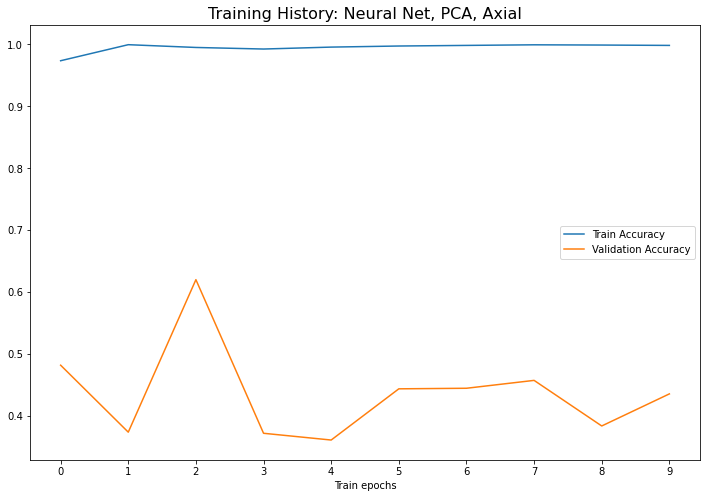

In [158]:
neural_net_pca_axial_val_predictions = neural_net_pca_axial.predict(X_val_pca_axial)
neural_net_pca_axial_val_predictions_sparse = np.argmax(neural_net_pca_axial_val_predictions, axis=-1)

print(classification_report(y_val_axial_shuff, neural_net_pca_axial_val_predictions_sparse))

plotConfMatrix(y_val_axial_shuff, neural_net_pca_axial_val_predictions_sparse, neural_net_pca_axial_title)
plotROCCurve(y_val_axial_shuff, neural_net_pca_axial_val_predictions, neural_net_pca_axial_title)
plotTrainingHistory(history, neural_net_pca_axial_title)

neural_net_pca_axial_accuracy, neural_net_pca_axial_precisions, neural_net_pca_axial_recalls = allClassPrecisionsandRecalls(y_val_axial_shuff.tolist(), neural_net_pca_axial_val_predictions_sparse.tolist())



### Neural Net With Regularizer

#### Coronal, All Unscaled

In [161]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

neural_net_reg_all_coronal = build_multiclass_simple_perceptron_model_with_regularizeer(4, 0.01)
numEpochs = 10

startTime = time.time()
history = neural_net_reg_all_coronal.fit(
  x = X_train_all_coronal,
  y = y_train_coronal_shuff,
  epochs=numEpochs,
  batch_size=32,
  validation_data = (X_val_all_coronal, y_val_coronal_shuff),
  verbose=1)
endTime = time.time()

neural_net_reg_all_coronal_time = (endTime - startTime)/60
neural_net_reg_all_coronal_title = 'Neural Net With Regularization, All, Coronal'

Epoch 1/10
101/101 [==============================] - 2s 13ms/step - loss: 245.2801 - accuracy: 0.5775 - recall_c1: 0.6879 - precision_c1: 0.6751 - recall_c2: 0.6610 - precision_c2: 0.6540 - recall_c3: 0.2764 - precision_c3: 0.2255 - recall_c4: 0.4392 - precision_c4: 0.4308 - val_loss: 45.2383 - val_accuracy: 0.3493 - val_recall_c1: 0.4212 - val_precision_c1: 0.6071 - val_recall_c2: 0.2900 - val_precision_c2: 0.4777 - val_recall_c3: 0.3963 - val_precision_c3: 0.3221 - val_recall_c4: 0.3157 - val_precision_c4: 0.1512
Epoch 2/10
101/101 [==============================] - 1s 9ms/step - loss: 24.6279 - accuracy: 0.5560 - recall_c1: 0.7929 - precision_c1: 0.5617 - recall_c2: 0.4962 - precision_c2: 0.8091 - recall_c3: 0.2385 - precision_c3: 0.2129 - recall_c4: 0.4759 - precision_c4: 0.6020 - val_loss: 22.0003 - val_accuracy: 0.3100 - val_recall_c1: 1.0000 - val_precision_c1: 0.3335 - val_recall_c2: 0.0118 - val_precision_c2: 0.1364 - val_recall_c3: 0.0000e+00 - val_precision_c3: 0.0000e+00 -

In [162]:
neural_net_reg_all_coronal_val_predictions = neural_net_reg_all_coronal.predict(X_val_all_coronal)
neural_net_reg_all_coronal_val_predictions_sparse = np.argmax(neural_net_reg_all_coronal_val_predictions, axis=-1)
print(classification_report(y_val_coronal_shuff, neural_net_reg_all_coronal_val_predictions_sparse))
neural_net_reg_all_coronal_accuracy, neural_net_reg_all_coronal_precisions, neural_net_reg_all_coronal_recalls = allClassPrecisionsandRecalls(y_val_coronal_shuff.tolist(), neural_net_reg_all_coronal_val_predictions_sparse.tolist())


22/22 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       210
           1       0.38      1.00      0.55       259
           2       0.00      0.00      0.00        77
           3       0.00      0.00      0.00       141

    accuracy                           0.38       687
   macro avg       0.09      0.25      0.14       687
weighted avg       0.14      0.38      0.21       687



/Users/karachristensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karachristensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karachristensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

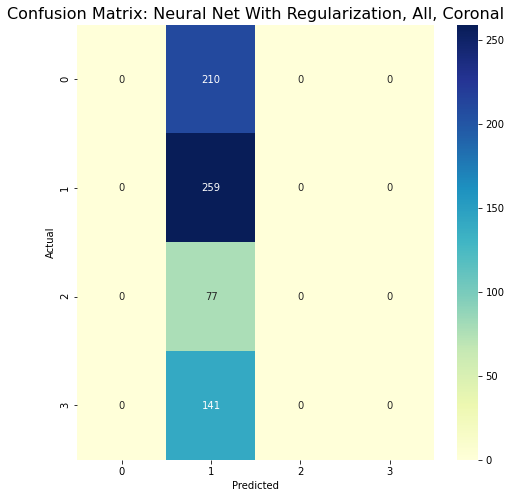

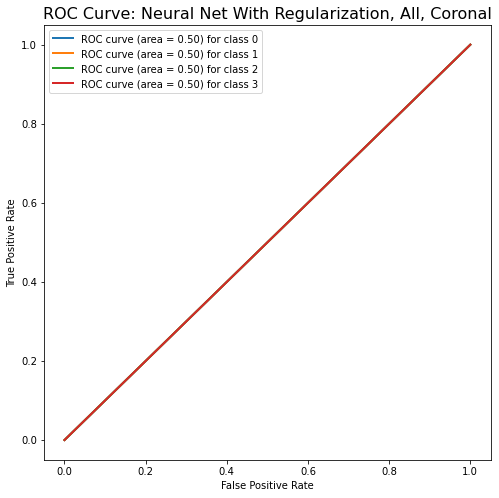

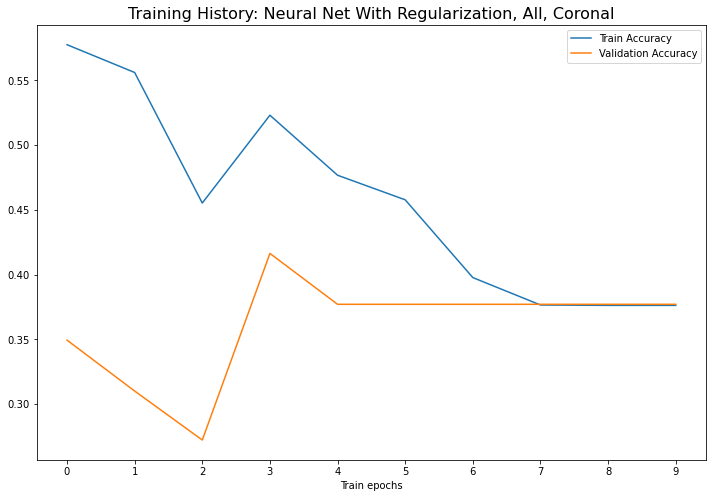

In [163]:
plotConfMatrix(y_val_coronal_shuff, neural_net_reg_all_coronal_val_predictions_sparse, neural_net_reg_all_coronal_title)
plotROCCurve(y_val_coronal_shuff, neural_net_reg_all_coronal_val_predictions, neural_net_reg_all_coronal_title)
plotTrainingHistory(history, neural_net_reg_all_coronal_title)

#### Coronal Scaled

In [164]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

neural_net_reg_scaled_coronal = build_multiclass_simple_perceptron_model_with_regularizeer(4, 0.01)
numEpochs = 10

startTime = time.time()
history = neural_net_reg_scaled_coronal.fit(
  x = X_train_scaled_coronal,
  y = y_train_coronal_shuff,
  epochs=numEpochs,
  batch_size=32,
  validation_data = (X_val_scaled_coronal, y_val_coronal_shuff),
  verbose=1)
endTime = time.time()

neural_net_reg_scaled_coronal_time = (endTime - startTime)/60
neural_net_reg_scaled_coronal_title = 'Neural Net With Regularization, Scaled, Coronal'

Epoch 1/10
101/101 [==============================] - 2s 13ms/step - loss: 53.3930 - accuracy: 0.8093 - recall_c1: 0.8108 - precision_c1: 0.8411 - recall_c2: 0.8725 - precision_c2: 0.8599 - recall_c3: 0.6365 - precision_c3: 0.6749 - recall_c4: 0.7807 - precision_c4: 0.7956 - val_loss: 29.7973 - val_accuracy: 0.5633 - val_recall_c1: 0.7616 - val_precision_c1: 0.4884 - val_recall_c2: 0.8692 - val_precision_c2: 0.6828 - val_recall_c3: 0.0379 - val_precision_c3: 0.0909 - val_recall_c4: 0.0065 - val_precision_c4: 0.0227
Epoch 2/10
101/101 [==============================] - 1s 8ms/step - loss: 23.9452 - accuracy: 0.8388 - recall_c1: 0.8314 - precision_c1: 0.8592 - recall_c2: 0.9032 - precision_c2: 0.8912 - recall_c3: 0.6293 - precision_c3: 0.6498 - recall_c4: 0.8163 - precision_c4: 0.8554 - val_loss: 21.7779 - val_accuracy: 0.2911 - val_recall_c1: 0.3714 - val_precision_c1: 0.6112 - val_recall_c2: 0.3673 - val_precision_c2: 0.3990 - val_recall_c3: 0.0557 - val_precision_c3: 0.0417 - val_reca

In [165]:
neural_net_reg_scaled_coronal_val_predictions = neural_net_reg_scaled_coronal.predict(X_val_scaled_coronal)
neural_net_reg_scaled_coronal_val_predictions_sparse = np.argmax(neural_net_reg_scaled_coronal_val_predictions, axis=-1)
print(classification_report(y_val_coronal_shuff, neural_net_reg_scaled_coronal_val_predictions_sparse))
neural_net_reg_scaled_coronal_accuracy, neural_net_reg_scaled_coronal_precisions, neural_net_reg_scaled_coronal_recalls = allClassPrecisionsandRecalls(y_val_coronal_shuff.tolist(), neural_net_reg_scaled_coronal_val_predictions_sparse.tolist())


22/22 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.60      0.42      0.50       210
           1       0.52      0.95      0.67       259
           2       0.26      0.06      0.10        77
           3       0.43      0.14      0.21       141

    accuracy                           0.52       687
   macro avg       0.45      0.40      0.37       687
weighted avg       0.50      0.52      0.46       687



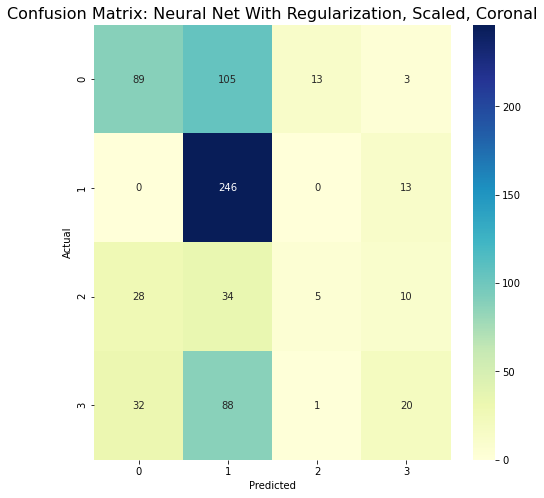

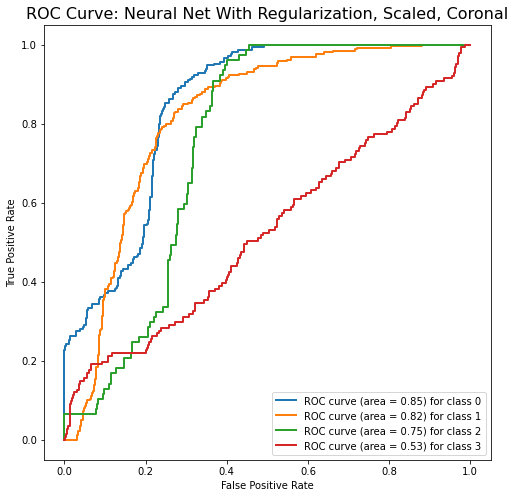

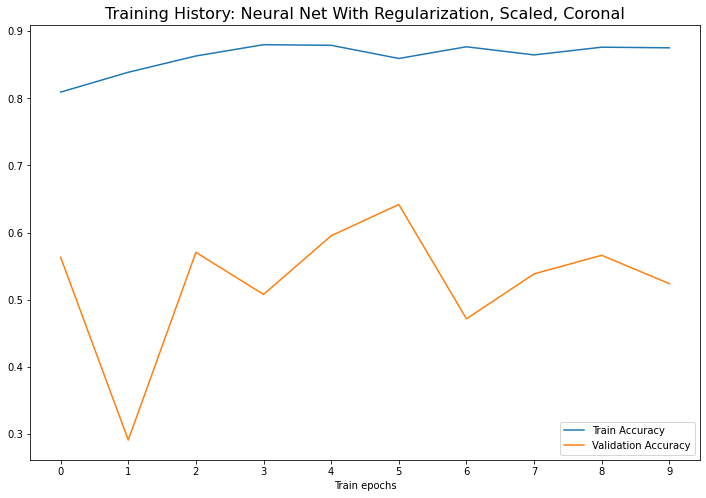

In [166]:
plotConfMatrix(y_val_coronal_shuff, neural_net_reg_scaled_coronal_val_predictions_sparse, neural_net_reg_scaled_coronal_title)
plotROCCurve(y_val_coronal_shuff, neural_net_reg_scaled_coronal_val_predictions, neural_net_reg_scaled_coronal_title)
plotTrainingHistory(history, neural_net_reg_scaled_coronal_title)

#### Coronal PCA

In [167]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

neural_net_reg_pca_coronal = build_multiclass_simple_perceptron_model_with_regularizeer(4, 0.01)
numEpochs = 10

startTime = time.time()
history = neural_net_reg_pca_coronal.fit(
  x = X_train_pca_coronal,
  y = y_train_coronal_shuff,
  epochs=numEpochs,
  batch_size=32,
  validation_data = (X_val_pca_coronal, y_val_coronal_shuff),
  verbose=1)
endTime = time.time()

neural_net_reg_pca_coronal_time = (endTime - startTime)/60
neural_net_reg_pca_coronal_title = 'Neural Net With Regularization, PCA, Coronal'

Epoch 1/10
101/101 [==============================] - 1s 4ms/step - loss: 6.3045 - accuracy: 0.9555 - recall_c1: 0.9649 - precision_c1: 0.9583 - recall_c2: 0.9656 - precision_c2: 0.9633 - recall_c3: 0.8832 - precision_c3: 0.8949 - recall_c4: 0.9540 - precision_c4: 0.9611 - val_loss: 2.9986 - val_accuracy: 0.5852 - val_recall_c1: 0.6971 - val_precision_c1: 0.7076 - val_recall_c2: 0.8887 - val_precision_c2: 0.6205 - val_recall_c3: 0.1050 - val_precision_c3: 0.1030 - val_recall_c4: 0.1059 - val_precision_c4: 0.3106
Epoch 2/10
101/101 [==============================] - 0s 2ms/step - loss: 1.0296 - accuracy: 0.9935 - recall_c1: 0.9958 - precision_c1: 0.9967 - recall_c2: 0.9974 - precision_c2: 0.9932 - recall_c3: 0.9194 - precision_c3: 0.9378 - recall_c4: 0.9930 - precision_c4: 0.9953 - val_loss: 1.8278 - val_accuracy: 0.6390 - val_recall_c1: 0.7584 - val_precision_c1: 0.7166 - val_recall_c2: 0.9275 - val_precision_c2: 0.6686 - val_recall_c3: 0.0720 - val_precision_c3: 0.0500 - val_recall_c4

In [168]:
neural_net_reg_pca_coronal_val_predictions = neural_net_reg_pca_coronal.predict(X_val_pca_coronal)
neural_net_reg_pca_coronal_val_predictions_sparse = np.argmax(neural_net_reg_pca_coronal_val_predictions, axis=-1)
print(classification_report(y_val_coronal_shuff, neural_net_reg_pca_coronal_val_predictions_sparse))
neural_net_reg_pca_coronal_accuracy, neural_net_reg_pca_coronal_precisions, neural_net_reg_pca_coronal_recalls = allClassPrecisionsandRecalls(y_val_coronal_shuff.tolist(), neural_net_reg_pca_coronal_val_predictions_sparse.tolist())


22/22 [==============================] - 0s 794us/step
              precision    recall  f1-score   support

           0       0.61      0.75      0.68       210
           1       0.71      0.95      0.81       259
           2       0.19      0.12      0.15        77
           3       0.59      0.16      0.25       141

    accuracy                           0.63       687
   macro avg       0.53      0.49      0.47       687
weighted avg       0.60      0.63      0.58       687



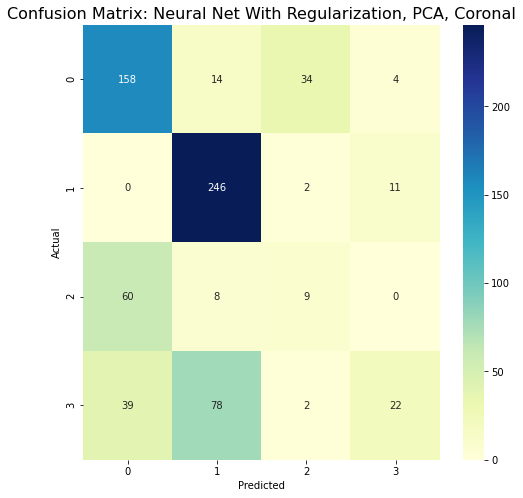

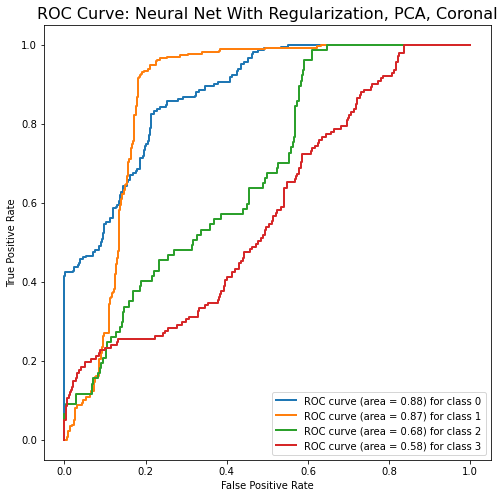

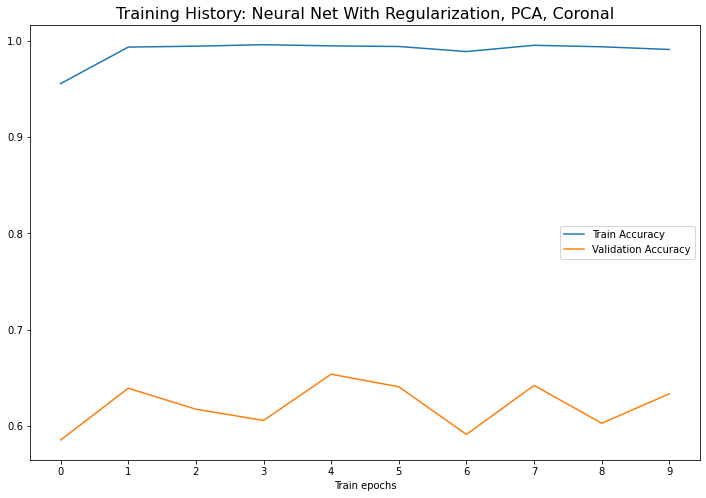

In [169]:
plotConfMatrix(y_val_coronal_shuff, neural_net_reg_pca_coronal_val_predictions_sparse, neural_net_reg_pca_coronal_title)
plotROCCurve(y_val_coronal_shuff, neural_net_reg_pca_coronal_val_predictions, neural_net_reg_pca_coronal_title)
plotTrainingHistory(history, neural_net_reg_pca_coronal_title)

#### Axial, All Unscaled

In [170]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

neural_net_reg_all_axial = build_multiclass_simple_perceptron_model_with_regularizeer(4, 0.01)
numEpochs = 10

startTime = time.time()
history = neural_net_reg_all_axial.fit(
  x = X_train_all_axial,
  y = y_train_axial_shuff,
  epochs=numEpochs,
  batch_size=32,
  validation_data = (X_val_all_axial, y_val_axial_shuff),
  verbose=1)
endTime = time.time()

neural_net_reg_all_axial_time = (endTime - startTime)/60
neural_net_reg_all_axial_title = 'Neural Net With Regularization, All, Axial'

Epoch 1/10
161/161 [==============================] - 3s 12ms/step - loss: 205.8256 - accuracy: 0.6409 - recall_c1: 0.7111 - precision_c1: 0.6874 - recall_c2: 0.7447 - precision_c2: 0.7718 - recall_c3: 0.3854 - precision_c3: 0.4091 - recall_c4: 0.4348 - precision_c4: 0.4298 - val_loss: 102.7803 - val_accuracy: 0.6182 - val_recall_c1: 0.5561 - val_precision_c1: 0.7974 - val_recall_c2: 1.0000 - val_precision_c2: 0.6503 - val_recall_c3: 0.0307 - val_precision_c3: 0.1429 - val_recall_c4: 0.1134 - val_precision_c4: 0.1760
Epoch 2/10
161/161 [==============================] - 1s 9ms/step - loss: 71.3354 - accuracy: 0.7453 - recall_c1: 0.8058 - precision_c1: 0.8107 - recall_c2: 0.8173 - precision_c2: 0.8611 - recall_c3: 0.5976 - precision_c3: 0.6299 - recall_c4: 0.5650 - precision_c4: 0.5652 - val_loss: 62.9861 - val_accuracy: 0.7655 - val_recall_c1: 1.0000 - val_precision_c1: 0.8465 - val_recall_c2: 0.9819 - val_precision_c2: 0.7332 - val_recall_c3: 0.6285 - val_precision_c3: 0.6981 - val_re

In [171]:
neural_net_reg_all_axial_val_predictions = neural_net_reg_all_axial.predict(X_val_all_axial)
neural_net_reg_all_axial_val_predictions_sparse = np.argmax(neural_net_reg_all_axial_val_predictions, axis=-1)
print(classification_report(y_val_axial_shuff, neural_net_reg_all_axial_val_predictions_sparse))
neural_net_reg_all_axial_accuracy, neural_net_reg_all_axial_precisions, neural_net_reg_all_axial_recalls = allClassPrecisionsandRecalls(y_val_axial_shuff.tolist(), neural_net_reg_all_axial_val_predictions_sparse.tolist())


35/35 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       282
           1       0.82      0.68      0.74       491
           2       0.00      0.00      0.00       126
           3       0.29      1.00      0.45       201

    accuracy                           0.49      1100
   macro avg       0.28      0.42      0.30      1100
weighted avg       0.42      0.49      0.41      1100



/Users/karachristensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karachristensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karachristensen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

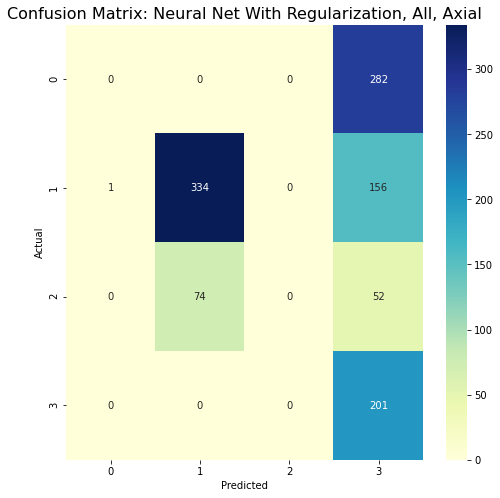

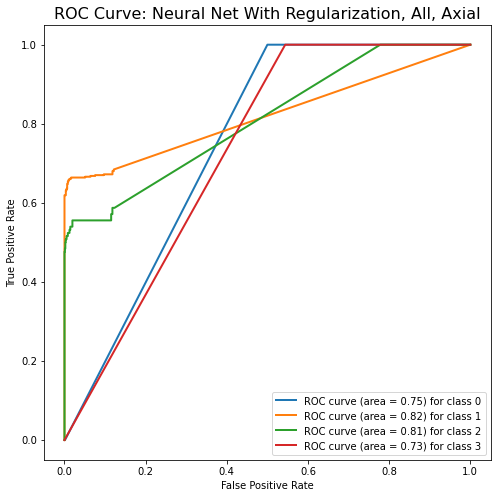

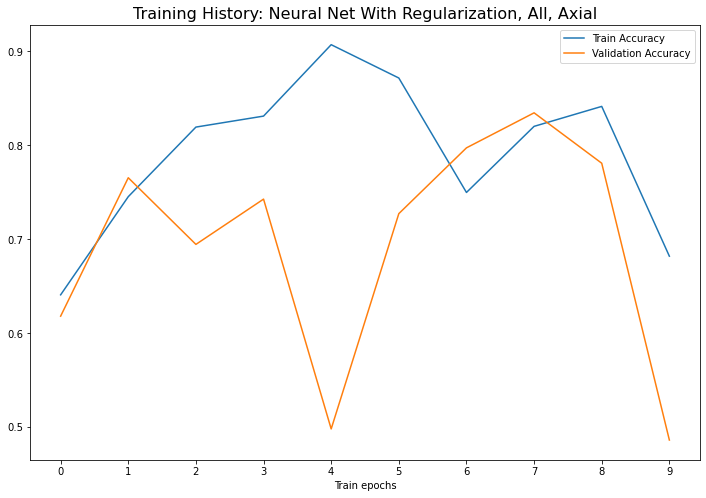

In [172]:
plotConfMatrix(y_val_axial_shuff, neural_net_reg_all_axial_val_predictions_sparse, neural_net_reg_all_axial_title)
plotROCCurve(y_val_axial_shuff, neural_net_reg_all_axial_val_predictions, neural_net_reg_all_axial_title)
plotTrainingHistory(history, neural_net_reg_all_axial_title)

#### Axial Scaled

In [173]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

neural_net_reg_scaled_axial = build_multiclass_simple_perceptron_model_with_regularizeer(4, 0.01)
numEpochs = 10

startTime = time.time()
history = neural_net_reg_scaled_axial.fit(
  x = X_train_scaled_axial,
  y = y_train_axial_shuff,
  epochs=numEpochs,
  batch_size=32,
  validation_data = (X_val_scaled_axial, y_val_axial_shuff),
  verbose=1)
endTime = time.time()

neural_net_reg_scaled_axial_time = (endTime - startTime)/60
neural_net_reg_scaled_axial_title = 'Neural Net With Regularization, Scaled, Axial'

Epoch 1/10
161/161 [==============================] - 2s 12ms/step - loss: 39.4540 - accuracy: 0.8106 - recall_c1: 0.7792 - precision_c1: 0.8122 - recall_c2: 0.8958 - precision_c2: 0.8755 - recall_c3: 0.5617 - precision_c3: 0.6248 - recall_c4: 0.7907 - precision_c4: 0.7925 - val_loss: 19.4168 - val_accuracy: 0.4836 - val_recall_c1: 0.4467 - val_precision_c1: 0.4906 - val_recall_c2: 0.4348 - val_precision_c2: 0.9481 - val_recall_c3: 0.0703 - val_precision_c3: 0.0659 - val_recall_c4: 0.8866 - val_precision_c4: 0.3669
Epoch 2/10
161/161 [==============================] - 1s 9ms/step - loss: 17.8388 - accuracy: 0.8472 - recall_c1: 0.8511 - precision_c1: 0.8053 - recall_c2: 0.9309 - precision_c2: 0.9096 - recall_c3: 0.5714 - precision_c3: 0.6911 - recall_c4: 0.8036 - precision_c4: 0.8674 - val_loss: 19.6136 - val_accuracy: 0.2273 - val_recall_c1: 0.2366 - val_precision_c1: 0.2052 - val_recall_c2: 0.2916 - val_precision_c2: 0.5942 - val_recall_c3: 0.2715 - val_precision_c3: 0.3739 - val_reca

In [174]:
neural_net_reg_scaled_axial_val_predictions = neural_net_reg_scaled_axial.predict(X_val_scaled_axial)
neural_net_reg_scaled_axial_val_predictions_sparse = np.argmax(neural_net_reg_scaled_axial_val_predictions, axis=-1)
print(classification_report(y_val_axial_shuff, neural_net_reg_scaled_axial_val_predictions_sparse))
neural_net_reg_scaled_axial_accuracy, neural_net_reg_scaled_axial_precisions, neural_net_reg_scaled_axial_recalls = allClassPrecisionsandRecalls(y_val_axial_shuff.tolist(), neural_net_reg_scaled_axial_val_predictions_sparse.tolist())


35/35 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.46      0.46      0.46       282
           1       0.60      0.41      0.49       491
           2       0.09      0.21      0.12       126
           3       0.00      0.00      0.00       201

    accuracy                           0.33      1100
   macro avg       0.29      0.27      0.27      1100
weighted avg       0.39      0.33      0.35      1100



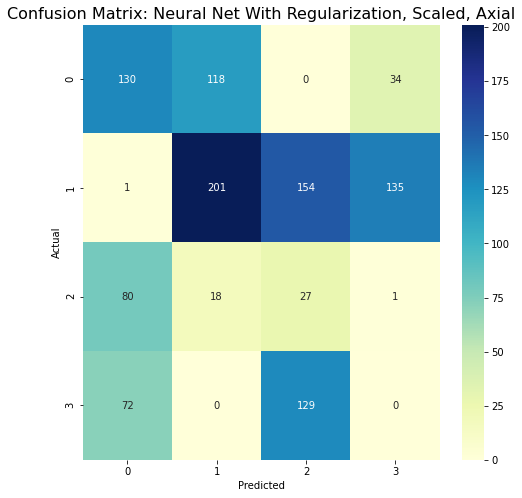

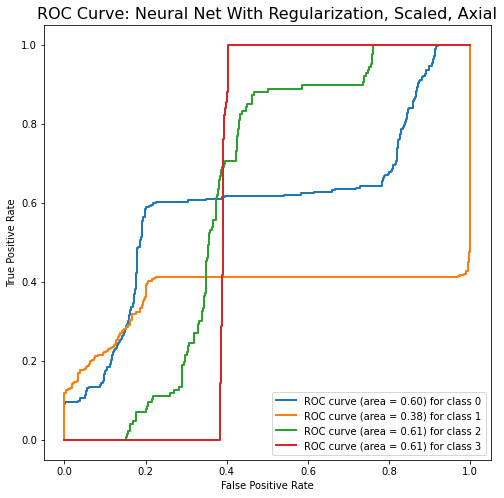

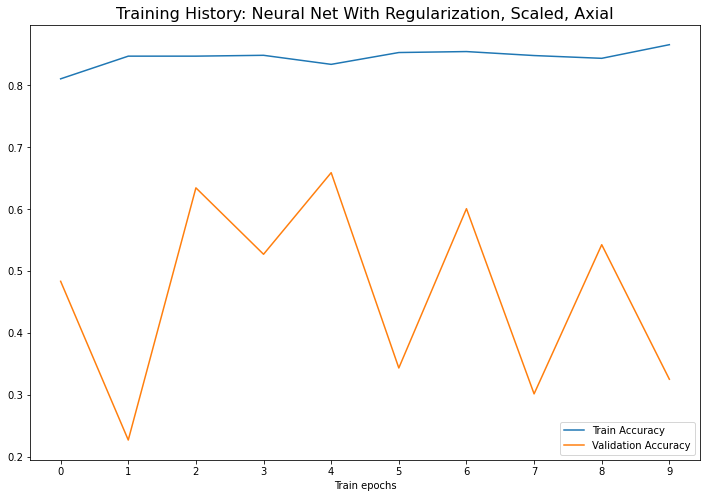

In [175]:
plotConfMatrix(y_val_axial_shuff, neural_net_reg_scaled_axial_val_predictions_sparse, neural_net_reg_scaled_axial_title)
plotROCCurve(y_val_axial_shuff, neural_net_reg_scaled_axial_val_predictions, neural_net_reg_scaled_axial_title)
plotTrainingHistory(history, neural_net_reg_scaled_axial_title)

#### Axial PCA

In [176]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

neural_net_reg_pca_axial = build_multiclass_simple_perceptron_model_with_regularizeer(4, 0.01)
numEpochs = 10

startTime = time.time()
history = neural_net_reg_pca_axial.fit(
  x = X_train_pca_axial,
  y = y_train_axial_shuff,
  epochs=numEpochs,
  batch_size=32,
  validation_data = (X_val_pca_axial, y_val_axial_shuff),
  verbose=1)
endTime = time.time()

neural_net_reg_pca_axial_time = (endTime - startTime)/60
neural_net_reg_pca_axial_title = 'Neural Net With Regularization, PCA, Axial'

Epoch 1/10
161/161 [==============================] - 1s 3ms/step - loss: 4.6890 - accuracy: 0.9630 - recall_c1: 0.9626 - precision_c1: 0.9547 - recall_c2: 0.9775 - precision_c2: 0.9770 - recall_c3: 0.8744 - precision_c3: 0.9081 - recall_c4: 0.9587 - precision_c4: 0.9601 - val_loss: 4.0938 - val_accuracy: 0.3718 - val_recall_c1: 0.4848 - val_precision_c1: 0.5872 - val_recall_c2: 0.1754 - val_precision_c2: 0.5404 - val_recall_c3: 0.1598 - val_precision_c3: 0.1450 - val_recall_c4: 0.8527 - val_precision_c4: 0.2721
Epoch 2/10
161/161 [==============================] - 0s 2ms/step - loss: 0.9649 - accuracy: 0.9893 - recall_c1: 0.9889 - precision_c1: 0.9793 - recall_c2: 0.9987 - precision_c2: 0.9951 - recall_c3: 0.9225 - precision_c3: 0.9599 - recall_c4: 0.9892 - precision_c4: 0.9850 - val_loss: 2.6437 - val_accuracy: 0.4436 - val_recall_c1: 0.4558 - val_precision_c1: 0.6827 - val_recall_c2: 0.2801 - val_precision_c2: 0.7772 - val_recall_c3: 0.4787 - val_precision_c3: 0.2644 - val_recall_c4

In [177]:
neural_net_reg_pca_axial_val_predictions = neural_net_reg_pca_axial.predict(X_val_pca_axial)
neural_net_reg_pca_axial_val_predictions_sparse = np.argmax(neural_net_reg_pca_axial_val_predictions, axis=-1)
print(classification_report(y_val_axial_shuff, neural_net_reg_pca_axial_val_predictions_sparse))
neural_net_reg_pca_axial_accuracy, neural_net_reg_pca_axial_precisions, neural_net_reg_pca_axial_recalls = allClassPrecisionsandRecalls(y_val_axial_shuff.tolist(), neural_net_reg_pca_axial_val_predictions_sparse.tolist())


35/35 [==============================] - 0s 781us/step
              precision    recall  f1-score   support

           0       0.62      0.50      0.55       282
           1       0.88      0.40      0.55       491
           2       0.15      0.23      0.18       126
           3       0.35      0.80      0.49       201

    accuracy                           0.48      1100
   macro avg       0.50      0.48      0.44      1100
weighted avg       0.64      0.48      0.50      1100



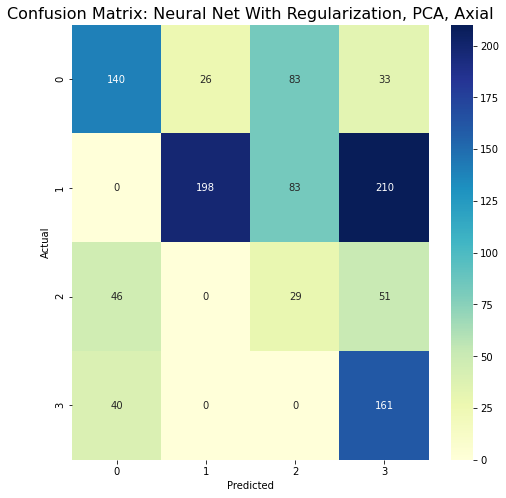

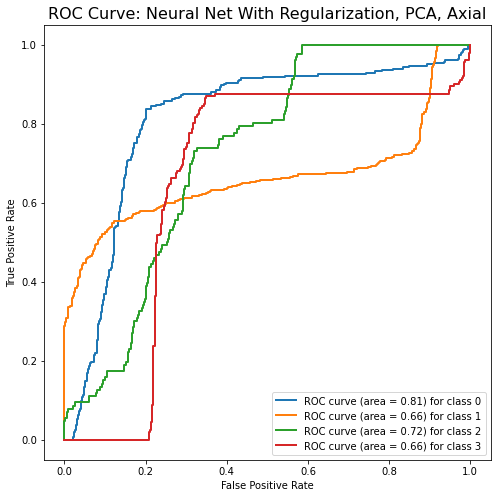

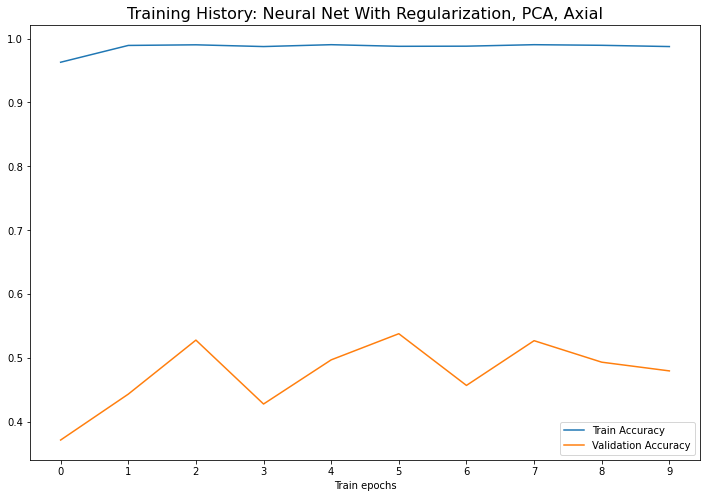

In [178]:
plotConfMatrix(y_val_axial_shuff, neural_net_reg_pca_axial_val_predictions_sparse, neural_net_reg_pca_axial_title)
plotROCCurve(y_val_axial_shuff, neural_net_reg_pca_axial_val_predictions, neural_net_reg_pca_axial_title)
plotTrainingHistory(history, neural_net_reg_pca_axial_title)

### XGBoost

#### Coronal, All, Unscaled

In [179]:
xgboost_all_coronal = XGBClassifier(tree_method='approx', max_bin=50, n_estimators=5)

startTime = time.time()
xgboost_all_coronal.fit(X_train_all_coronal, y_train_coronal_shuff)
endTime = time.time()

xgboost_all_coronal_time = (endTime - startTime)/60
xgboost_all_coronal_title = 'XGBoost, All, Coronal'

In [180]:
xgboost_all_coronal_val_predictions = xgboost_all_coronal.predict(X_val_all_coronal)

error = (xgboost_all_coronal_val_predictions != y_val_coronal_shuff.flatten()).sum()/len(xgboost_all_coronal_val_predictions)
print('Error:%.3f'% error)
print('Val prediction accuracy: %.3f'% (1-error))
xgboost_all_coronal_accuracy = (1-error)

print(classification_report(y_val_coronal_shuff, xgboost_all_coronal_val_predictions))

Error:0.376
Val prediction accuracy: 0.624
              precision    recall  f1-score   support

           0       0.64      0.86      0.73       210
           1       0.74      0.84      0.79       259
           2       0.05      0.04      0.04        77
           3       0.54      0.20      0.29       141

    accuracy                           0.62       687
   macro avg       0.49      0.48      0.46       687
weighted avg       0.59      0.62      0.59       687



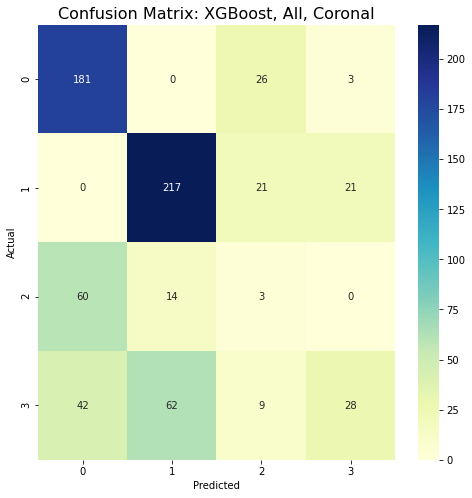

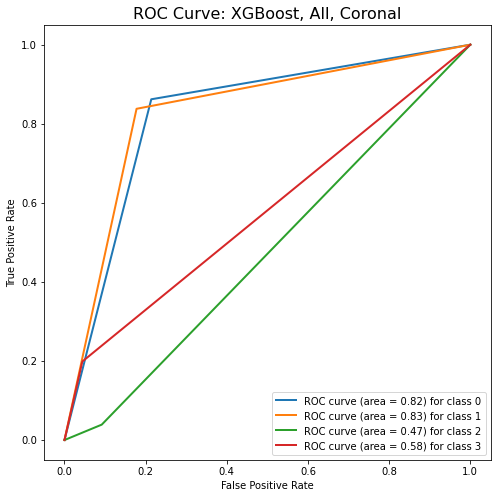

In [181]:
plotConfMatrix(y_val_coronal_shuff, xgboost_all_coronal_val_predictions, xgboost_all_coronal_title)
plotROCCurveSparse(y_val_coronal_shuff, xgboost_all_coronal_val_predictions, xgboost_all_coronal_title)

#### Coronal, Scaled

In [182]:
xgboost_scaled_coronal = XGBClassifier(tree_method='approx', max_bin=50, n_estimators=5)

startTime = time.time()
xgboost_scaled_coronal.fit(X_train_scaled_coronal, y_train_coronal_shuff)
endTime = time.time()

xgboost_scaled_coronal_time = (endTime - startTime)/60
xgboost_scaled_coronal_title = 'XGBoost, Scaled, Coronal'

In [183]:
xgboost_scaled_coronal_val_predictions = xgboost_scaled_coronal.predict(X_val_scaled_coronal)

error = (xgboost_scaled_coronal_val_predictions != y_val_coronal_shuff.flatten()).sum()/len(xgboost_scaled_coronal_val_predictions)
print('Error:%.3f'% error)
print('Val prediction accuracy: %.3f'% (1-error))
xgboost_scaled_coronal_accuracy = (1-error)

print(classification_report(y_val_coronal_shuff, xgboost_scaled_coronal_val_predictions))

Error:0.376
Val prediction accuracy: 0.624
              precision    recall  f1-score   support

           0       0.64      0.86      0.73       210
           1       0.74      0.84      0.79       259
           2       0.05      0.04      0.04        77
           3       0.54      0.20      0.29       141

    accuracy                           0.62       687
   macro avg       0.49      0.48      0.46       687
weighted avg       0.59      0.62      0.59       687



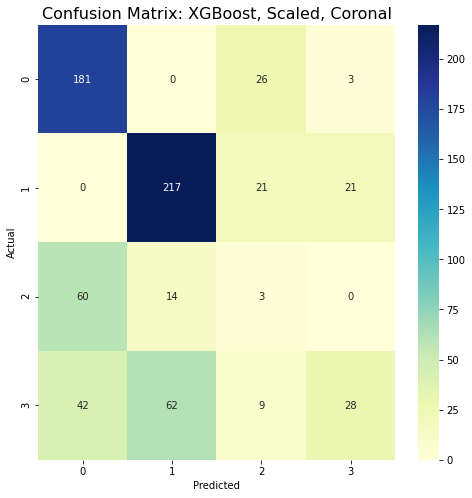

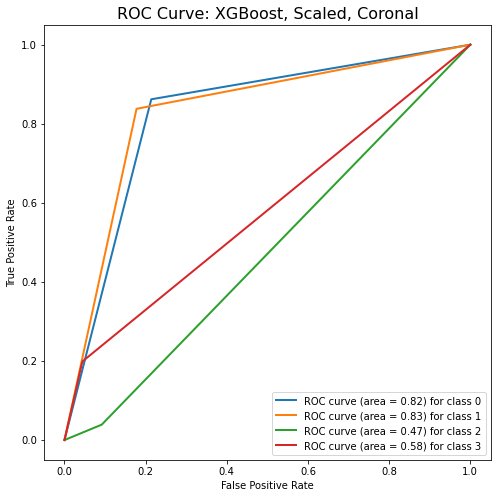

In [184]:
plotConfMatrix(y_val_coronal_shuff, xgboost_scaled_coronal_val_predictions, xgboost_scaled_coronal_title)
plotROCCurveSparse(y_val_coronal_shuff, xgboost_scaled_coronal_val_predictions, xgboost_scaled_coronal_title)

#### Coronal, PCA

In [185]:
xgboost_pca_coronal = XGBClassifier(tree_method='approx', max_bin=50, n_estimators=5)

startTime = time.time()
xgboost_pca_coronal.fit(X_train_pca_coronal, y_train_coronal_shuff)
endTime = time.time()

xgboost_pca_coronal_time = (endTime - startTime)/60
xgboost_pca_coronal_title = 'XGBoost, PCA, Coronal'

In [186]:
xgboost_pca_coronal_val_predictions = xgboost_pca_coronal.predict(X_val_pca_coronal)

error = (xgboost_pca_coronal_val_predictions != y_val_coronal_shuff.flatten()).sum()/len(xgboost_pca_coronal_val_predictions)
print('Error:%.3f'% error)
print('Val prediction accuracy: %.3f'% (1-error))
xgboost_pca_coronal_accuracy = (1-error)

print(classification_report(y_val_coronal_shuff, xgboost_pca_coronal_val_predictions))

Error:0.272
Val prediction accuracy: 0.728
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       210
           1       0.71      0.99      0.83       259
           2       0.47      0.09      0.15        77
           3       0.54      0.27      0.36       141

    accuracy                           0.73       687
   macro avg       0.64      0.57      0.56       687
weighted avg       0.68      0.73      0.67       687



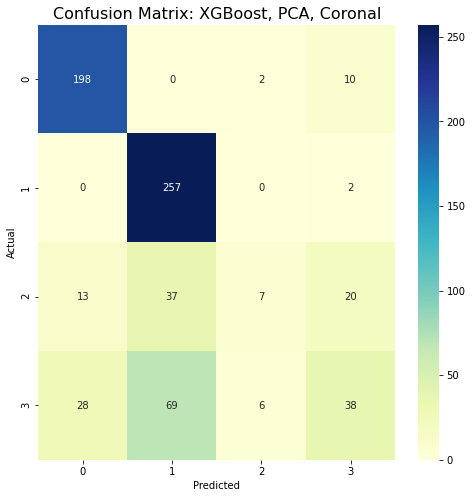

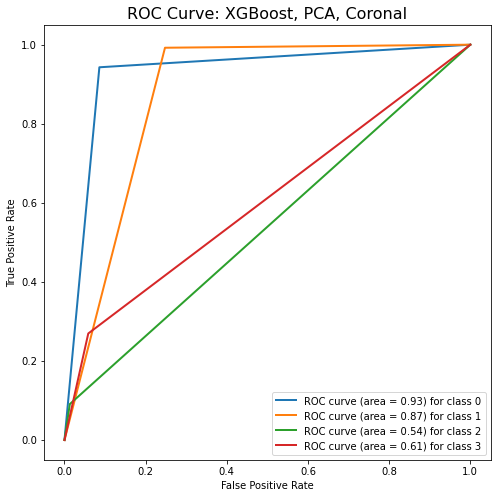

In [187]:
plotConfMatrix(y_val_coronal_shuff, xgboost_pca_coronal_val_predictions, xgboost_pca_coronal_title)
plotROCCurveSparse(y_val_coronal_shuff, xgboost_pca_coronal_val_predictions, xgboost_pca_coronal_title)

#### Axial, All, Unscaled

In [188]:
xgboost_all_axial = XGBClassifier(tree_method='approx', max_bin=50, n_estimators=5)

startTime = time.time()
xgboost_all_axial.fit(X_train_all_axial, y_train_axial_shuff)
endTime = time.time()

xgboost_all_axial_time = (endTime - startTime)/60
xgboost_all_axial_title = 'XGBoost, All, Axial'

In [189]:
xgboost_all_axial_val_predictions = xgboost_all_axial.predict(X_val_all_axial)

error = (xgboost_all_axial_val_predictions != y_val_axial_shuff.flatten()).sum()/len(xgboost_all_axial_val_predictions)
print('Error:%.3f'% error)
print('Val prediction accuracy: %.3f'% (1-error))
xgboost_all_axial_accuracy = (1-error)

print(classification_report(y_val_axial_shuff, xgboost_all_axial_val_predictions))

Error:0.231
Val prediction accuracy: 0.769
              precision    recall  f1-score   support

           0       0.67      0.87      0.75       282
           1       0.96      0.82      0.88       491
           2       0.61      0.29      0.39       126
           3       0.63      0.82      0.72       201

    accuracy                           0.77      1100
   macro avg       0.72      0.70      0.69      1100
weighted avg       0.79      0.77      0.76      1100



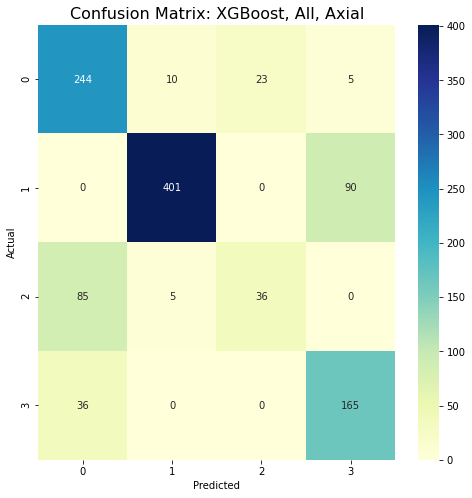

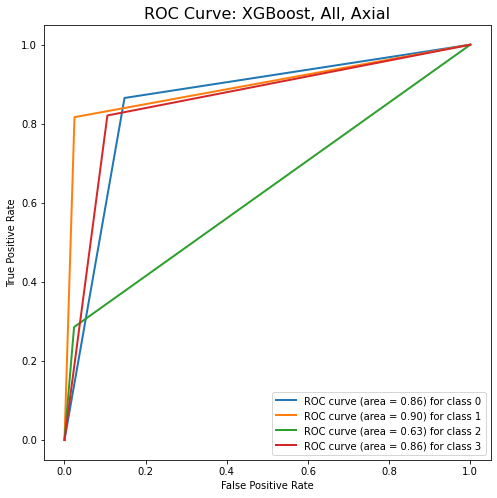

In [190]:
plotConfMatrix(y_val_axial_shuff, xgboost_all_axial_val_predictions, xgboost_all_axial_title)
plotROCCurveSparse(y_val_axial_shuff, xgboost_all_axial_val_predictions, xgboost_all_axial_title)

#### Axial Scaled

In [191]:
xgboost_scaled_axial = XGBClassifier(tree_method='approx', max_bin=50, n_estimators=5)

startTime = time.time()
xgboost_scaled_axial.fit(X_train_scaled_axial, y_train_axial_shuff)
endTime = time.time()

xgboost_scaled_axial_time = (endTime - startTime)/60
xgboost_scaled_axial_title = 'XGBoost, Scaled, Axial'

In [192]:
xgboost_scaled_axial_val_predictions = xgboost_scaled_axial.predict(X_val_scaled_axial)

error = (xgboost_scaled_axial_val_predictions != y_val_axial_shuff.flatten()).sum()/len(xgboost_scaled_axial_val_predictions)
print('Error:%.3f'% error)
print('Val prediction accuracy: %.3f'% (1-error))
xgboost_scaled_axial_accuracy = (1-error)

print(classification_report(y_val_axial_shuff, xgboost_scaled_axial_val_predictions))

Error:0.231
Val prediction accuracy: 0.769
              precision    recall  f1-score   support

           0       0.67      0.87      0.75       282
           1       0.96      0.82      0.88       491
           2       0.61      0.29      0.39       126
           3       0.63      0.82      0.72       201

    accuracy                           0.77      1100
   macro avg       0.72      0.70      0.69      1100
weighted avg       0.79      0.77      0.76      1100



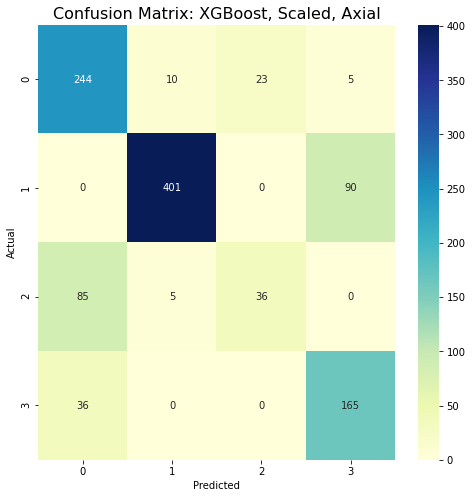

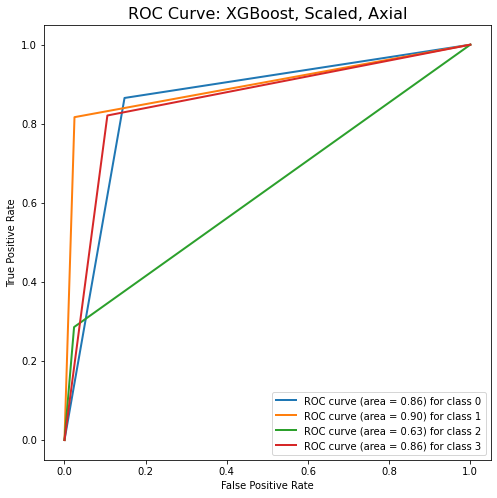

In [193]:
plotConfMatrix(y_val_axial_shuff, xgboost_scaled_axial_val_predictions, xgboost_scaled_axial_title)
plotROCCurveSparse(y_val_axial_shuff, xgboost_scaled_axial_val_predictions, xgboost_scaled_axial_title)

#### Axial PCA

In [194]:
xgboost_pca_axial = XGBClassifier(tree_method='approx', max_bin=50, n_estimators=5)

startTime = time.time()
xgboost_pca_axial.fit(X_train_pca_axial, y_train_axial_shuff)
endTime = time.time()

xgboost_pca_axial_time = (endTime - startTime)/60
xgboost_pca_axial_title = 'XGBoost, PCA, Axial'

In [195]:
xgboost_pca_axial_val_predictions = xgboost_pca_axial.predict(X_val_pca_axial)

error = (xgboost_pca_axial_val_predictions != y_val_axial_shuff.flatten()).sum()/len(xgboost_pca_axial_val_predictions)
print('Error:%.3f'% error)
print('Val prediction accuracy: %.3f'% (1-error))
xgboost_pca_axial_accuracy = (1-error)

print(classification_report(y_val_axial_shuff, xgboost_pca_axial_val_predictions))

Error:0.355
Val prediction accuracy: 0.645
              precision    recall  f1-score   support

           0       0.69      0.94      0.79       282
           1       0.84      0.70      0.76       491
           2       0.62      0.60      0.61       126
           3       0.13      0.12      0.13       201

    accuracy                           0.64      1100
   macro avg       0.57      0.59      0.57      1100
weighted avg       0.65      0.64      0.64      1100



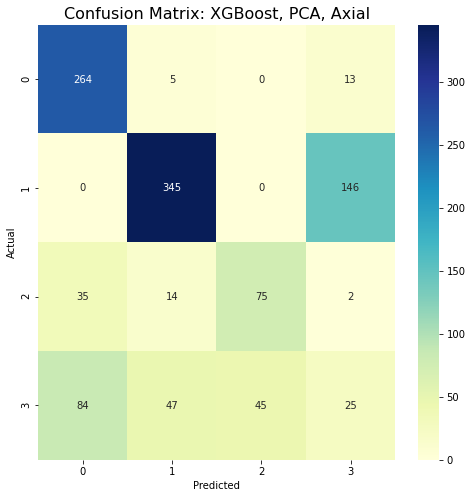

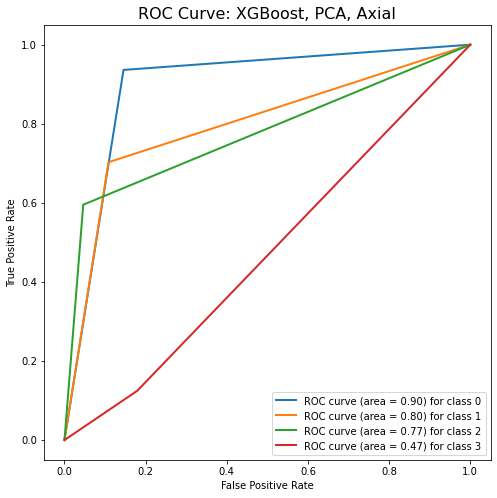

In [196]:
plotConfMatrix(y_val_axial_shuff, xgboost_pca_axial_val_predictions, xgboost_pca_axial_title)
plotROCCurveSparse(y_val_axial_shuff, xgboost_pca_axial_val_predictions, xgboost_pca_axial_title)

In [199]:
table = [
    ['Model', 'Image Type', 'Data Type', 'Accuracy', 'Training Time'],
    ['Multiclass Logistic Regression', 'Coronal', 'Complete Unscaled Feature Vector', str(round(logistic_regression_all_coronal_accuracy*100, 2)) + '%', 
         str(round(logistic_regression_all_coronal_time, 4)) + ' minutes'],
    ['Multiclass Logistic Regression', 'Coronal', 'Complete Scaled Feature Vector', str(round(logistic_regression_scaled_coronal_accuracy*100, 2)) + '%', 
         str(round(logistic_regression_scaled_coronal_time, 4)) + ' minutes'],
    ['Multiclass Logistic Regression', 'Coronal', 'PCA Applied Feature Vector', str(round(logistic_regression_pca_coronal_accuracy*100, 2)) + '%', 
         str(round(logistic_regression_pca_coronal_time, 4)) + ' minutes'],
    
    ['Multiclass Logistic Regression', 'Axial', 'Complete Unscaled Feature Vector', str(round(logistic_regression_all_axial_accuracy*100, 2)) + '%', 
         str(round(logistic_regression_all_axial_time, 4)) + ' minutes'],
    ['Multiclass Logistic Regression', 'Axial', 'Complete Scaled Feature Vector', str(round(logistic_regression_scaled_axial_accuracy*100, 2)) + '%', 
         str(round(logistic_regression_scaled_axial_time, 4)) + ' minutes'],
    ['Multiclass Logistic Regression', 'Axial', 'PCA Applied Feature Vector', str(round(logistic_regression_pca_axial_accuracy*100, 2)) + '%', 
         str(round(logistic_regression_pca_axial_time, 4)) + ' minutes'],
    
    
    ['Neural Net', 'Coronal', 'Complete Unscaled Feature Vector', str(round(neural_net_all_coronal_accuracy*100, 2)) + '%', 
         str(round(neural_net_all_coronal_time, 4)) + ' minutes'],
    ['Neural Net', 'Coronal', 'Complete Scaled Feature Vector', str(round(neural_net_scaled_coronal_accuracy*100, 2)) + '%', 
         str(round(neural_net_scaled_coronal_time, 4)) + ' minutes'],
    ['Neural Net', 'Coronal', 'PCA Applied Feature Vector', str(round(neural_net_pca_coronal_accuracy*100, 2)) + '%', 
         str(round(neural_net_pca_coronal_time, 4)) + ' minutes'],
    
    ['Neural Net', 'Axial', 'Complete Unscaled Feature Vector', str(round(neural_net_all_axial_accuracy*100, 2)) + '%', 
         str(round(neural_net_all_axial_time, 4)) + ' minutes'],
    ['Neural Net', 'Axial', 'Complete Scaled Feature Vector', str(round(neural_net_scaled_axial_accuracy*100, 2)) + '%', 
         str(round(neural_net_scaled_axial_time, 4)) + ' minutes'],
    ['Neural Net', 'Axial', 'PCA Applied Feature Vector', str(round(neural_net_pca_axial_accuracy*100, 2)) + '%', 
         str(round(neural_net_pca_axial_time, 4)) + ' minutes'],
    
    
    ['Neural Net With Regularization', 'Coronal', 'Complete Unscaled Feature Vector', str(round(neural_net_reg_all_coronal_accuracy*100, 2)) + '%', 
         str(round(neural_net_reg_all_coronal_time, 4)) + ' minutes'],
    ['Neural Net With Regularization', 'Coronal', 'Complete Scaled Feature Vector', str(round(neural_net_reg_scaled_coronal_accuracy*100, 2)) + '%', 
         str(round(neural_net_reg_scaled_coronal_time, 4)) + ' minutes'],
    ['Neural Net With Regularization', 'Coronal', 'PCA Applied Feature Vector', str(round(neural_net_reg_pca_coronal_accuracy*100, 2)) + '%', 
         str(round(neural_net_reg_pca_coronal_time, 4)) + ' minutes'],
    
    ['Neural Net With Regularization', 'Axial', 'Complete Unscaled Feature Vector', str(round(neural_net_reg_all_axial_accuracy*100, 2)) + '%', 
         str(round(neural_net_reg_all_axial_time, 4)) + ' minutes'],
    ['Neural Net With Regularization', 'Axial', 'Complete Scaled Feature Vector', str(round(neural_net_reg_scaled_axial_accuracy*100, 2)) + '%', 
         str(round(neural_net_reg_scaled_axial_time, 4)) + ' minutes'],
    ['Neural Net With Regularization', 'Axial', 'PCA Applied Feature Vector', str(round(neural_net_reg_pca_axial_accuracy*100, 2)) + '%', 
         str(round(neural_net_reg_pca_axial_time, 4)) + ' minutes'],
    
    
    ['XGBoost', 'Coronal', 'Complete Unscaled Feature Vector', str(round(xgboost_all_coronal_accuracy*100, 2)) + '%', 
         str(round(xgboost_all_coronal_time, 4)) + ' minutes'],
    ['XGBoost', 'Coronal', 'Complete Scaled Feature Vector', str(round(xgboost_scaled_coronal_accuracy*100, 2)) + '%', 
         str(round(xgboost_scaled_coronal_time, 4)) + ' minutes'],
    ['XGBoost', 'Coronal', 'PCA Applied Feature Vector', str(round(xgboost_pca_coronal_accuracy*100, 2)) + '%', 
         str(round(xgboost_pca_coronal_time, 4)) + ' minutes'],
    
    ['XGBoost', 'Axial', 'Complete Unscaled Feature Vector', str(round(xgboost_all_axial_accuracy*100, 2)) + '%', 
         str(round(xgboost_all_axial_time, 4)) + ' minutes'],
    ['XGBoost', 'Axial', 'Complete Scaled Feature Vector', str(round(xgboost_scaled_axial_accuracy*100, 2)) + '%', 
         str(round(xgboost_scaled_axial_time, 4)) + ' minutes'],
    ['XGBoost', 'Axial', 'PCA Applied Feature Vector', str(round(xgboost_pca_axial_accuracy*100, 2)) + '%', 
         str(round(xgboost_pca_axial_time, 4)) + ' minutes']
]
spans1 = []
# for i in range(1, 41, 4):
for i in range(1, 24, 6):
    for k in range(1):
        currSpan = [[j, k] for j in range(i, i+6)]
        spans1.append(currSpan)
        
        
for i in range(1, 24, 3):
    for k in range(1, 2):
        currSpan = [[j, k] for j in range(i, i+3)]
        spans1.append(currSpan)

my_spans = spans1

print(dashtable.data2rst(table, 
                         spans=my_spans, 
                         use_headers=True, 
                         center_cells=False))

+--------------------------------+------------+----------------------------------+----------+----------------+
| Model                          | Image Type | Data Type                        | Accuracy | Training Time  |
+================================+============+==================================+==========+================+
| Multiclass Logistic Regression | Coronal    | Complete Unscaled Feature Vector | 68.27%   | 0.1174 minutes |
|                                |            +----------------------------------+----------+----------------+
|                                |            | Complete Scaled Feature Vector   | 65.79%   | 0.1011 minutes |
|                                |            +----------------------------------+----------+----------------+
|                                |            | PCA Applied Feature Vector       | 62.59%   | 0.0613 minutes |
|                                +------------+----------------------------------+----------+----------------+
|